# Part 2

In this part, I will merge the dataframes of each variable, perform train-test split, EDA, the stationarity tests and seasonnally adjust the variables, if need be.

In [ ]:
import pandas as pd
import numpy as np
#Connect to API
from datetime import date
import datetime

#Library for Google Colab
from google.colab import drive

#Library for Plotting
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

#Library for Data Preprocessing and Cleaning
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [ ]:
today = str(datetime.date.today())
today

'2020-09-02'

#1. Load Data



# Table with Categories

In [ ]:
Cat_df=pd.read_excel(path+'/Table_Cat_GT.xlsx')
Cat_df.head()

,GT,GT code,Cat name
0,Food & Drink: 71,71,Food & Drink
1,Baked Goods: 907,907,Baked Goods
2,Meat & Seafood: 909,909,Meat & Seafood
3,Fruits & Vegetables: 908,908,Fruits & Vegetables
4,Candy & Sweets: 906,906,Candy & Sweets


# Load Macroeco variables, GT and CS

## Disposable Income

In [ ]:
# Disposable Income - UK Real net national disposable income per capita CVM SA
DI_df=pd.read_excel(path+'/0_Diss_DI.xlsx')
DI_df.columns = ['quarter', 'DI']
DI_df.set_index('quarter', inplace=True)
DI_df=DI_df[:-2]
DI_df.head()

,DI
quarter,
2004Q4,6090
2005Q1,6074
2005Q2,6248
2005Q3,6161
2005Q4,6264


In [ ]:
DI_df.index = pd.to_datetime(DI_df.index)
quarter_index = DI_df.index.to_period('Q')
DI_df.index = pd.PeriodIndex(DI_df.index, freq='Q')
DI_df.index.dtype

period[Q-DEC]

## United Kingdom 3-Month Bond Yield 

In [ ]:
# Treasury Bill United Kingdom 3-Month Bond Yield 
Tb_df=pd.read_excel(path+'/0_UK 3m Bond Yield.xlsx')
Tb_df['date'] = pd.to_datetime(Tb_df['Date'])
Tb_df.set_index('date', inplace=True)
Tb_df['3m Bond']=Tb_df['3m Bond'].interpolate(method='time')
Tb_df.head()

,Date,3m Bond
date,,
2004-01-01,2004-01-01,4.089
2004-02-01,2004-02-01,4.140
2004-03-01,2004-03-01,4.284
2004-04-01,2004-04-01,4.355
2004-05-01,2004-05-01,4.530


In [ ]:
Tb_df.isna().sum()

Date       0
3m Bond    0
dtype: int64

In [ ]:
Tb_df['quarter']= pd.PeriodIndex(Tb_df.Date, freq='Q')
Tb_df=Tb_df.groupby('quarter').mean()
Tb_df=Tb_df[:-2]
Tb_df.drop(Tb_df.index[:3], inplace=True)
Tb_df.head()

,3m Bond
quarter,
2004Q4,4.819667
2005Q1,4.881667
2005Q2,4.880667
2005Q3,4.609728
2005Q4,4.530333


In [ ]:
# merge DI and TB
merged_df_DI_TB=DI_df.merge(Tb_df,left_index=True, right_index=True )
merged_df_DI_TB.head()

,DI,3m Bond
quarter,,
2004Q4,6090,4.819667
2005Q1,6074,4.881667
2005Q2,6248,4.880667
2005Q3,6161,4.609728
2005Q4,6264,4.530333


## CCI


In [ ]:
#CCI
cci_df=pd.read_excel(path+'/0_Diss_cci.xlsx', names=['date', 'cci'])
cci_df.head()

,date,cci
0,2004-10-31,-5.7
1,2004-11-30,-4.0
2,2004-12-31,-4.8
3,2005-01-31,-4.4
4,2005-02-28,-3.3


In [ ]:
cci_df['quarter'] = pd.PeriodIndex(cci_df.date, freq='Q')
# calculate quarterly values
cci = cci_df.groupby('quarter').mean()
cci.head()

,cci
quarter,
2004Q4,-4.833333
2005Q1,-3.366667
2005Q2,-4.500000
2005Q3,-4.533333
2005Q4,-6.733333


In [ ]:
cci.tail()

,cci
quarter,
2018Q2,-6.433333
2018Q3,-5.666667
2018Q4,-8.100000
2019Q1,-11.266667
2019Q2,-9.966667


In [ ]:
# merge DI + TB and CCI
merged_DI_TB_CCI=merged_df_DI_TB.merge(cci,left_index=True, right_index=True )
merged_DI_TB_CCI.head()

,DI,3m Bond,cci
quarter,,,
2004Q4,6090,4.819667,-4.833333
2005Q1,6074,4.881667,-3.366667
2005Q2,6248,4.880667,-4.500000
2005Q3,6161,4.609728,-4.533333
2005Q4,6264,4.530333,-6.733333


## CPI

In [ ]:
# CPI INDEX 00: ALL ITEMS 2015=100
#CPI
CPI_df=pd.read_excel(path+'/0_Diss_CPI Index Q.xlsx')
CPI_df.set_index('quarter', inplace=True)
CPI= CPI_df[:-4]
CPI.index = pd.to_datetime(CPI.index)
CPI.index = pd.PeriodIndex(CPI.index, freq='Q')
CPI.head()

,CPI
quarter,
2004Q4,77.1
2005Q1,77.3
2005Q2,78.0
2005Q3,78.4
2005Q4,78.8


In [ ]:
# merge DI + TB + CCI and CPI
merged_DI_TB_CCI_CPI=merged_DI_TB_CCI.merge(CPI,left_index=True, right_index=True )
merged_DI_TB_CCI_CPI.head()

,DI,3m Bond,cci,CPI
quarter,,,,
2004Q4,6090,4.819667,-4.833333,77.1
2005Q1,6074,4.881667,-3.366667,77.3
2005Q2,6248,4.880667,-4.500000,78.0
2005Q3,6161,4.609728,-4.533333,78.4
2005Q4,6264,4.530333,-6.733333,78.8


## VIX

In [ ]:
# VIX FTSE
vix_df=pd.read_excel(path+'/0_Diss_FTSE VIX 100.xlsx')
vix_df['quarter'] = pd.PeriodIndex(vix_df.Date, freq='Q')
vix=vix_df.groupby('quarter').mean()
vix.drop(['Open','High', 'Low', 'Change %'], axis=1, inplace=True)
vix.drop(vix.index[0], axis=0, inplace=True)
vix.columns=['vix']
vix.head()

,vix
quarter,
2004Q4,12.500000
2005Q1,10.836667
2005Q2,11.336667
2005Q3,10.836667
2005Q4,12.873333


In [ ]:
# merge DI + TB + CCI + CPI and VIX
merged_macro=merged_DI_TB_CCI_CPI.merge(vix,left_index=True, right_index=True )
merged_macro.head()

,DI,3m Bond,cci,CPI,vix
quarter,,,,,
2004Q4,6090,4.819667,-4.833333,77.1,12.500000
2005Q1,6074,4.881667,-3.366667,77.3,10.836667
2005Q2,6248,4.880667,-4.500000,78.0,11.336667
2005Q3,6161,4.609728,-4.533333,78.4,10.836667
2005Q4,6264,4.530333,-6.733333,78.8,12.873333


## Save merged Macrovar datasets

In [ ]:
merged_macro.to_csv(path+'merged_macro.csv')

## GT

In [ ]:
GT_df=pd.read_csv(path+'/GT_raw_data.csv')
GT_df['quarter'] = pd.PeriodIndex(pd.to_datetime(GT_df['date']), freq='Q')
GT=GT_df.groupby('quarter').mean()
GT.drop(GT.index[:3], axis=0, inplace=True)
GT_df=GT[:-4]

# Transpose to merge with categories
GT_df_T=GT_df.T
GT_df_T['cat']=GT_df_T.index
# reset index
GT_df_T.reset_index(inplace=True)
GT_df_T.head()

quarter,index,2004Q4,2005Q1,2005Q2,2005Q3,2005Q4,2006Q1,2006Q2,2006Q3,2006Q4,2007Q1,2007Q2,2007Q3,2007Q4,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,cat
0,50,75.666667,80.000000,81.666667,88.333333,79.666667,80.000000,78.333333,86.000000,77.333333,80.000000,75.333333,79.000000,73.333333,67.666667,65.666667,63.333333,56.666667,57.000000,54.666667,56.000000,52.666667,52.000000,50.000000,50.666667,52.000000,55.333333,55.000000,55.333333,53.666667,52.333333,51.333333,52.666667,50.666667,50.666667,50.000000,48.666667,50.000000,47.333333,46.000000,48.666667,46.000000,46.000000,45.666667,47.666667,44.000000,43.000000,43.333333,45.666667,43.666667,42.333333,42.666667,46.333333,44.666667,44.000000,42.666667,43.666667,43.000000,41.666667,43.000000,50
1,65,89.333333,90.333333,93.000000,94.666667,93.333333,94.000000,91.000000,95.666667,92.000000,85.666667,86.333333,83.666667,79.666667,77.000000,73.000000,72.666667,68.000000,66.333333,66.666667,66.666667,64.666667,61.666667,59.333333,62.000000,58.666667,69.000000,72.000000,72.333333,71.333333,68.000000,68.333333,73.000000,69.000000,66.666667,67.000000,65.666667,68.333333,64.000000,63.666667,64.333333,65.333333,61.000000,61.000000,61.000000,63.000000,63.333333,61.000000,62.666667,63.666667,59.000000,61.666667,62.666667,64.666667,59.666667,60.000000,60.000000,63.000000,58.666667,60.333333,65
2,68,73.000000,67.000000,68.000000,66.666667,78.666667,69.333333,70.333333,70.333333,81.000000,69.666667,71.666667,67.666667,77.666667,65.000000,63.666667,62.333333,71.000000,61.000000,58.666667,60.333333,69.666667,58.666667,57.666667,56.666667,65.000000,70.333333,70.666667,70.000000,84.000000,70.666667,72.000000,71.333333,85.000000,71.000000,71.000000,70.333333,85.333333,70.000000,71.666667,69.000000,85.000000,69.333333,69.333333,69.666667,84.333333,71.333333,73.666667,73.000000,90.666667,72.666667,75.000000,77.666667,95.000000,74.000000,75.333333,75.333333,90.333333,73.333333,75.666667,68
3,71,49.000000,48.666667,45.333333,45.333333,52.333333,50.000000,46.666667,48.333333,54.000000,50.666667,46.666667,46.666667,52.000000,47.333333,43.000000,42.333333,46.666667,43.333333,39.666667,41.333333,45.333333,41.666667,39.000000,41.666667,45.000000,53.666667,51.333333,52.333333,60.333333,56.000000,53.333333,52.666667,61.000000,59.333333,55.333333,55.333333,62.666667,59.000000,56.000000,55.333333,62.000000,60.000000,55.666667,57.000000,62.666667,63.333333,59.333333,60.000000,67.333333,64.333333,62.666667,66.000000,71.666667,68.666667,62.666667,64.666667,70.333333,67.666667,65.000000,71
4,74,85.000000,94.333333,95.333333,83.000000,88.000000,95.666667,89.333333,80.333333,82.666667,90.333333,83.333333,72.666667,76.000000,78.000000,74.666667,65.000000,67.666667,75.333333,68.666667,64.333333,66.333333,75.000000,64.000000,57.000000,60.333333,65.666667,59.666667,53.666667,57.666667,60.666667,54.666667,49.000000,52.333333,60.333333,52.666667,45.666667,49.666667,52.000000,49.333333,44.666667,46.333333,51.000000,48.666667,41.333333,42.666667,45.666667,46.000000,39.666667,41.666667,45.333333,42.666667,40.000000,42.666667,46.000000,41.000000,37.333333,38.333333,41.666667,40.000000,74


In [ ]:
#convert GT code to int in the table
Cat_df['GT code'] = Cat_df['GT code'].astype(int)

#convert cat in GT dataset in integer
GT_df_T['cat']=GT_df_T['cat'].astype(int)

# Merge the two dataframes
GT_Cat= pd.merge(GT_df_T, Cat_df, how="left", left_on='cat', right_on='GT code')

# Put the column with the name and number of the categories in the first place
first_col = GT_Cat.pop('GT')
GT_Cat.insert(0, 'Categ_name', first_col)

# Delete columns we don't need anymore
GT_Cat.drop(['index','cat','GT code', 'Cat name'], axis=1, inplace=True)
GT_Cat_df=GT_Cat.T

# Put the 1st row as a header
new_header = GT_Cat_df.iloc[0] 
GT_Cat_df = GT_Cat_df[1:] 
GT_Cat_df.columns = new_header
GT_Cat_df.head()

Categ_name,Transportation & Logistics: 50,Hobbies & Leisure: 65,Apparel: 68,Food & Drink: 71,Education: 74,Vehicle Parts & Accessories: 89,Tobacco Products: 123,Clothing Accessories: 124,Vehicle Maintenance: 138,Hotels & Accommodations: 179,Air Travel: 203,Health Insurance: 249,Sporting Goods: 263,Home Furnishings: 270,Motorcycles: 273,Restaurants: 276,Audio Equipment: 361,Lottery & Sweepstakes: 364,Apartments & Residential Rentals: 378,Mobile & Wireless: 382,Beer: 404,Wine: 405,Liquor: 406,Home Insurance: 465,Home Financing: 466,Auto Insurance: 467,Domestic Services: 472,Non-Alcoholic Beverages: 560,Camera & Photo Equipment: 573,Drugs & Medications: 646,Electricity: 658,Animal Products & Services: 882,Candy & Sweets: 906,Baked Goods: 907,Fruits & Vegetables: 908,Meat & Seafood: 909,Kitchen & Dining: 951,Mail & Package Delivery: 1150,Automotive Industry: 1190,Bicycles & Accessories: 1191,Vehicle Fuels & Lubricants: 1269,Small Kitchen Appliances: 1292,Major Kitchen Appliances: 1293,Water Supply & Treatment: 1349
2004Q4,75.6667,89.3333,73,49,85,84,89.3333,82.6667,67.3333,72.6667,70.6667,55,68.3333,71,74.3333,78.3333,92,32.6667,66.6667,96.6667,60,79.3333,61.3333,65.3333,65.6667,72,52,61,94,86,75.6667,65.3333,77,18,38.3333,35.3333,82.3333,67.6667,71,62.6667,75,71,85,32.6667
2005Q1,80,90.3333,67,48.6667,94.3333,94,87.3333,70,77.6667,89.3333,88,69,70.6667,72,81.3333,77.6667,88,35,87.6667,95.3333,64,63.3333,64,85.3333,90.6667,94.6667,63.6667,62.6667,81.3333,93.6667,77.3333,70.3333,83,18,41.6667,32.6667,82.6667,69.3333,77.3333,64.3333,83.6667,61.6667,85,57.3333
2005Q2,81.6667,93,68,45.3333,95.3333,97,83.3333,65,77.3333,87.3333,85,70,81.6667,63.3333,96.3333,74.3333,77,38,87.3333,87.6667,65,66.3333,52.3333,85,86.3333,95.3333,61.3333,65,80.6667,86.6667,71.6667,68.6667,71.3333,17.3333,43.6667,30.3333,75.6667,72.3333,81.3333,77.6667,85.3333,58,80,36
2005Q3,88.3333,94.6667,66.6667,45.3333,83,95.3333,77.3333,68,82,91.3333,90.3333,74,88.3333,70,90,76,78,49,94.6667,86.6667,64.6667,65.6667,55.3333,94.6667,86.6667,95.3333,60.3333,67,83.3333,84.3333,74.3333,72,67.6667,16.6667,45.6667,32.6667,76.3333,73.3333,71.6667,86,88.6667,57,84,33.3333
2005Q4,79.6667,93.3333,78.6667,52.3333,88,92.6667,86,83.6667,72.3333,67.6667,69.3333,63,75,74.3333,74.3333,81.6667,90.3333,39.6667,67,88,63.3333,76.6667,58.6667,69.3333,68.3333,72.6667,54.6667,70,88,82.6667,75.3333,70.6667,83,20,43.6667,39,86,77.3333,69,68,84.6667,70.6667,83.3333,33.3333


In [ ]:
# create a multiindex where both quarters and categories are indices
stacked_df = GT_Cat_df.stack(0)
GT_stk_df = pd.DataFrame(stacked_df.values, index=stacked_df.index)

# give the proper name for the column
GT_stk_df.columns = ["GT"]

# Name correctly the quarter index
GT_stk_df.index.names = ['quarter','Categ_name']
GT_stk_df.head()

GT
quarter Categ_name                             
2004Q4  Transportation & Logistics: 50  75.6667
        Hobbies & Leisure: 65           89.3333
        Apparel: 68                          73
        Food & Drink: 71                     49
        Education: 74                        85

In [ ]:
# Merge GT and VAR TEST

merged_GT_macro = GT_stk_df.merge(merged_macro,left_index=True, right_index=True )
merged_GT_macro.head()

GT    DI  ...   CPI   vix
quarter Categ_name                                     ...            
2004Q4  Transportation & Logistics: 50  75.6667  6090  ...  77.1  12.5
        Hobbies & Leisure: 65           89.3333  6090  ...  77.1  12.5
        Apparel: 68                          73  6090  ...  77.1  12.5
        Food & Drink: 71                     49  6090  ...  77.1  12.5
        Education: 74                        85  6090  ...  77.1  12.5

[5 rows x 6 columns]

In [ ]:
# swap around quarters and categories
merged_GT_macro.index = merged_GT_macro.index.swaplevel(0, 1)
# sort the data first by categories, then by quarters
merged_GT_macro.sort_index(inplace=True)
merged_GT_macro.head()

GT    DI   3m Bond       cci   CPI        vix
Categ_name      quarter                                                    
Air Travel: 203 2004Q4   70.6667  6090  4.819667 -4.833333  77.1  12.500000
                2005Q1        88  6074  4.881667 -3.366667  77.3  10.836667
                2005Q2        85  6248  4.880667 -4.500000  78.0  11.336667
                2005Q3   90.3333  6161  4.609728 -4.533333  78.4  10.836667
                2005Q4   69.3333  6264  4.530333 -6.733333  78.8  12.873333

## Merged GT and Macro datasets load

Save the dataset with the macroeconomic variables and Google Trends.

In [ ]:
merged_GT_macro.to_csv(path+'merged_GT_macro.csv')

In [ ]:
merged_GT_macro=pd.read_csv(path+'merged_GT_macro.csv')
merged_GT_macro.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix
0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000
1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667
2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667
3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667
4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333


In [ ]:
# Creation of a column combinning the quarter and the category to merge it with the dataset GT+ macrovar
merged_GT_macro['quarter_cat'] = merged_GT_macro['quarter']+'_'+merged_GT_macro['Categ_name']
merged_GT_macro.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,quarter_cat
0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000,2004Q4_Air Travel: 203
1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667,2005Q1_Air Travel: 203
2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667,2005Q2_Air Travel: 203
3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667,2005Q3_Air Travel: 203
4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333,2005Q4_Air Travel: 203


In [ ]:
merged_GT_macro.dtypes

Categ_name      object
quarter         object
GT             float64
DI               int64
3m Bond        float64
cci            float64
CPI            float64
vix            float64
quarter_cat     object
dtype: object

In [ ]:
merged_GT_macro['quarter']= pd.PeriodIndex(pd.to_datetime(merged_GT_macro['quarter']), freq='Q')
merged_GT_macro.dtypes

Categ_name            object
quarter        period[Q-DEC]
GT                   float64
DI                     int64
3m Bond              float64
cci                  float64
CPI                  float64
vix                  float64
quarter_cat           object
dtype: object

## Consumer Spending

In [ ]:
# Consumer Spending
CS_df=pd.read_excel(path+'/0_Diss_Consumer Spending.xlsx')

# Transform the index date into quarters in the right format
CS_df.set_index('quarter', inplace=True)
CS_df.index = pd.to_datetime(CS_df.index)
CS_df.index = pd.PeriodIndex(CS_df.index, freq='Q')

# remove last 2 quarters
CS_df=CS_df[:-2]
CS_df.head()

,Food & Drink,Baked Goods,Meat & Seafood,Fruits & Vegetables,Candy & Sweets,Non-Alcoholic Beverages,Liquor,Wine,Beer,Tobacco Products,Apparel,Apartments & Residential Rentals,Water Supply & Treatment,Electricity,Home Furnishings,Major Kitchen Appliances,Small Kitchen Appliances,Kitchen & Dining,Home Financing,Domestic Services,Drugs & Medications,Automotive Industry,Motorcycles,Bicycles & Accessories,Vehicle Parts & Accessories,Vehicle Fuels & Lubricants,Vehicle Maintenance,Transportation & Logistics,Air Travel,Mail & Package Delivery,Mobile & Wireless,Audio Equipment,Camera & Photo Equipment,Sporting Goods,Animal Products & Services,Hobbies & Leisure,Lottery & Sweepstakes,Education,Restaurants,Hotels & Accommodations,Clothing Accessories,Home Insurance,Health Insurance,Auto Insurance
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004Q4,16626,2456,3932,3623,1758,2085,803,1475,854,3852,10502,45881,752,2419,2630,1188,249,1290,732,858,894,9793,181,272,904,5653,4123,1145,3324,176,169,1278,1028,561,704,1849,2081,2655,15185,3523,1523,1384,342,933
2005Q1,16794,2450,3951,3723,1758,2060,778,1472,839,3873,10767,46505,757,2357,2627,1391,186,1337,747,879,835,9669,158,261,1182,5765,4100,1190,3344,185,179,1409,1079,546,730,1783,2150,2655,15665,3481,1467,1122,445,943
2005Q2,16894,2493,4058,3716,1677,2122,815,1506,809,3841,10744,47218,847,2402,2605,1308,170,1279,719,1085,754,9619,162,247,926,5991,4085,1215,3332,191,192,1349,1093,562,723,1962,2223,2653,15683,3412,1446,1275,451,929
2005Q3,16747,2432,3961,3739,1692,2087,830,1538,854,3839,10818,47801,853,2508,2674,1203,311,1297,704,814,705,9806,160,239,948,6096,4156,1182,3442,190,199,1365,1138,521,723,1935,2276,2696,15615,3334,1519,1337,491,959
2005Q4,17188,2534,4026,3755,1754,2148,825,1521,827,3910,10986,48151,861,2705,2669,1382,249,1359,747,1223,652,9698,138,236,1206,6245,4205,1234,3435,189,206,1379,1169,630,734,2007,2461,2756,15883,3477,1557,994,345,630


In [ ]:
# Transpose the dataframe
CS_df_T=CS_df.T
CS_df_T['cat']=CS_df_T.index

# reset index
CS_df_T.reset_index(inplace=True)

# Merge dataframe with the category table with the CS dataset
CS_Cat= pd.merge(CS_df_T, Cat_df, how="left", left_on='cat', right_on='Cat name')
CS_Cat.head()

,index,2004Q4,2005Q1,2005Q2,2005Q3,2005Q4,2006Q1,2006Q2,2006Q3,2006Q4,2007Q1,2007Q2,2007Q3,2007Q4,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,cat,GT,GT code,Cat name
0,Food & Drink,16626,16794,16894,16747,17188,17264,17304,17751,17709,17920,18056,18171,18859,18894,19457,19751,19565,19726,20195,19895,19904,19679,20517,20416,20351,21313,21389,22010,21948,22197,22008,22179,22841,22783,22811,23090,23348,23378,23345,23447,23162,22661,22768,22849,23090,23351,23640,24016,24231,24658,25026,25245,25609,25876,25989,26201,26312,26314,26581,Food & Drink,Food & Drink: 71,71,Food & Drink
1,Baked Goods,2456,2450,2493,2432,2534,2572,2570,2596,2604,2613,2679,2749,2847,2891,2912,3022,2963,3051,3201,3251,3273,3154,3290,3197,3157,3253,3284,3327,3353,3344,3285,3399,3580,3554,3658,3621,3625,3646,3641,3701,3663,3705,3744,3802,3857,3874,3907,3930,3958,4001,4082,4106,4160,4174,4143,4172,4199,4251,4280,Baked Goods,Baked Goods: 907,907,Baked Goods
2,Meat & Seafood,3932,3951,4058,3961,4026,4032,4041,4131,4130,4084,4081,4083,4297,4280,4307,4378,4174,4314,4475,4451,4448,4369,4412,4467,4360,4578,4615,4741,4738,4848,4892,4911,4991,5004,4992,5004,5137,5124,5113,5229,5185,5022,4999,5019,5039,5144,5248,5300,5371,5460,5575,5619,5727,5705,5693,5712,5688,5689,5715,Meat & Seafood,Meat & Seafood: 909,909,Meat & Seafood
3,Fruits & Vegetables,3623,3723,3716,3739,3755,3883,3885,3987,4027,4178,4210,4168,4269,4141,4345,4577,4565,4528,4687,4426,4388,4306,4617,4606,4794,5189,5114,5379,5138,5283,5118,5136,5314,5201,5276,5442,5537,5584,5523,5528,5424,5235,5387,5419,5452,5503,5603,5809,5882,5987,6196,6181,6277,6323,6298,6314,6381,6432,6456,Fruits & Vegetables,Fruits & Vegetables: 908,908,Fruits & Vegetables
4,Candy & Sweets,1758,1758,1677,1692,1754,1703,1749,1756,1763,1808,1828,1818,1835,1869,2041,1880,1961,1945,1872,1865,1884,2043,2072,2138,2134,2166,2242,2260,2326,2313,2356,2455,2512,2507,2501,2544,2528,2578,2623,2592,2568,2552,2523,2489,2604,2681,2696,2729,2751,2930,2742,2824,2811,2909,2974,3059,3139,3047,3181,Candy & Sweets,Candy & Sweets: 906,906,Candy & Sweets


In [ ]:
# Put the column with the name and number of the category in the 1st position
f_col = CS_Cat.pop('GT')
CS_Cat.insert(0, 'Categ_name', f_col)

# Remove the columns we don't need anymore
CS_Cat.drop(['index','cat','GT code', 'Cat name'], axis=1, inplace=True)

# transpose the dataframe
CS_Cat_df=CS_Cat.T

# Put the 1st row as a header
new_head = CS_Cat_df.iloc[0] 
CS_Cat_df = CS_Cat_df[1:] 
CS_Cat_df.columns = new_head
CS_Cat_df.head()

Categ_name,Food & Drink: 71,Baked Goods: 907,Meat & Seafood: 909,Fruits & Vegetables: 908,Candy & Sweets: 906,Non-Alcoholic Beverages: 560,Liquor: 406,Wine: 405,Beer: 404,Tobacco Products: 123,Apparel: 68,Apartments & Residential Rentals: 378,Water Supply & Treatment: 1349,Electricity: 658,Home Furnishings: 270,Major Kitchen Appliances: 1293,Small Kitchen Appliances: 1292,Kitchen & Dining: 951,Home Financing: 466,Domestic Services: 472,Drugs & Medications: 646,Automotive Industry: 1190,Motorcycles: 273,Bicycles & Accessories: 1191,Vehicle Parts & Accessories: 89,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Transportation & Logistics: 50,Air Travel: 203,Mail & Package Delivery: 1150,Mobile & Wireless: 382,Audio Equipment: 361,Camera & Photo Equipment: 573,Sporting Goods: 263,Animal Products & Services: 882,Hobbies & Leisure: 65,Lottery & Sweepstakes: 364,Education: 74,Restaurants: 276,Hotels & Accommodations: 179,Clothing Accessories: 124,Home Insurance: 465,Health Insurance: 249,Auto Insurance: 467
2004Q4,16626,2456,3932,3623,1758,2085,803,1475,854,3852,10502,45881,752,2419,2630,1188,249,1290,732,858,894,9793,181,272,904,5653,4123,1145,3324,176,169,1278,1028,561,704,1849,2081,2655,15185,3523,1523,1384,342,933
2005Q1,16794,2450,3951,3723,1758,2060,778,1472,839,3873,10767,46505,757,2357,2627,1391,186,1337,747,879,835,9669,158,261,1182,5765,4100,1190,3344,185,179,1409,1079,546,730,1783,2150,2655,15665,3481,1467,1122,445,943
2005Q2,16894,2493,4058,3716,1677,2122,815,1506,809,3841,10744,47218,847,2402,2605,1308,170,1279,719,1085,754,9619,162,247,926,5991,4085,1215,3332,191,192,1349,1093,562,723,1962,2223,2653,15683,3412,1446,1275,451,929
2005Q3,16747,2432,3961,3739,1692,2087,830,1538,854,3839,10818,47801,853,2508,2674,1203,311,1297,704,814,705,9806,160,239,948,6096,4156,1182,3442,190,199,1365,1138,521,723,1935,2276,2696,15615,3334,1519,1337,491,959
2005Q4,17188,2534,4026,3755,1754,2148,825,1521,827,3910,10986,48151,861,2705,2669,1382,249,1359,747,1223,652,9698,138,236,1206,6245,4205,1234,3435,189,206,1379,1169,630,734,2007,2461,2756,15883,3477,1557,994,345,630


In [ ]:
# create a multiindex where both quarters and categories are indices
stacked_CS = CS_Cat_df.stack(0)
CS_stk_df = pd.DataFrame(stacked_CS.values, index=stacked_CS.index)

# give the proper name for the column
CS_stk_df.columns = ["CS"]

# Name correctly the quarter index
CS_stk_df.index.names = ['quarter','Categ_name']
CS_stk_df.head()

CS
quarter Categ_name                     
2004Q4  Food & Drink: 71          16626
        Baked Goods: 907           2456
        Meat & Seafood: 909        3932
        Fruits & Vegetables: 908   3623
        Candy & Sweets: 906        1758

In [ ]:
CS_stk_df.index.names

FrozenList(['quarter', 'Categ_name'])

In [ ]:
CS_stk_df.reset_index(inplace=True)
CS_stk_df.head()

,quarter,Categ_name,CS
0,2004Q4,Food & Drink: 71,16626
1,2004Q4,Baked Goods: 907,2456
2,2004Q4,Meat & Seafood: 909,3932
3,2004Q4,Fruits & Vegetables: 908,3623
4,2004Q4,Candy & Sweets: 906,1758


In [ ]:
# Transform type of quarter to string
CS_stk_df['quarter']=CS_stk_df['quarter'].astype(str)

# Creation of a column combining the quarter and the category to merge it with the dataset GT+ macrovar
CS_stk_df['quarter_cat'] = CS_stk_df['quarter']+'_'+CS_stk_df['Categ_name']
CS_stk_df.head()

,quarter,Categ_name,CS,quarter_cat
0,2004Q4,Food & Drink: 71,16626,2004Q4_Food & Drink: 71
1,2004Q4,Baked Goods: 907,2456,2004Q4_Baked Goods: 907
2,2004Q4,Meat & Seafood: 909,3932,2004Q4_Meat & Seafood: 909
3,2004Q4,Fruits & Vegetables: 908,3623,2004Q4_Fruits & Vegetables: 908
4,2004Q4,Candy & Sweets: 906,1758,2004Q4_Candy & Sweets: 906


In [ ]:
# retransform the type of quarter
CS_stk_df['quarter']= pd.PeriodIndex(pd.to_datetime(CS_stk_df['quarter']), freq='Q')
CS_stk_df.head()

,quarter,Categ_name,CS,quarter_cat
0,2004Q4,Food & Drink: 71,16626,2004Q4_Food & Drink: 71
1,2004Q4,Baked Goods: 907,2456,2004Q4_Baked Goods: 907
2,2004Q4,Meat & Seafood: 909,3932,2004Q4_Meat & Seafood: 909
3,2004Q4,Fruits & Vegetables: 908,3623,2004Q4_Fruits & Vegetables: 908
4,2004Q4,Candy & Sweets: 906,1758,2004Q4_Candy & Sweets: 906


In [ ]:
merged_df=merged_GT_macro.merge(CS_stk_df[['quarter_cat','CS']], left_on='quarter_cat', right_on='quarter_cat')
merged_df.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,quarter_cat,CS
0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000,2004Q4_Air Travel: 203,3324
1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667,2005Q1_Air Travel: 203,3344
2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667,2005Q2_Air Travel: 203,3332
3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667,2005Q3_Air Travel: 203,3442
4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333,2005Q4_Air Travel: 203,3435


# Dataset with merged datasets

In [ ]:
merged_df.drop('quarter_cat',axis=1, inplace=True)
merged_df.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS
0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000,3324
1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667,3344
2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667,3332
3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667,3442
4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333,3435


In [ ]:
merged_df.to_csv(path+'/merged_data.csv')

In [ ]:
merged_df=pd.read_csv(path+'/merged_data.csv')
merged_df.head()

,Unnamed: 0,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS
0,0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000,3324
1,1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667,3344
2,2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667,3332
3,3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667,3442
4,4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333,3435


In [ ]:
merged_df_light= merged_df[merged_df.Categ_name != 'Food & Drink: 71']
merged_df_light.head()

,Unnamed: 0,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS
0,0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000,3324
1,1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667,3344
2,2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667,3332
3,3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667,3442
4,4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333,3435


In [ ]:
print (merged_df.shape)
print (merged_df_light.shape)
print (merged_df_light.columns)

(2596, 10)
(2537, 10)
Index(['Unnamed: 0', 'Categ_name', 'quarter', 'GT', 'DI', '3m Bond', 'cci',
       'CPI', 'vix', 'CS'],
      dtype='object')


In [ ]:
merged_df_light.drop('Unnamed: 0', axis=1, inplace=True)
merged_df_light.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS
0,Air Travel: 203,2004Q4,70.666667,6090,4.819667,-4.833333,77.1,12.500000,3324
1,Air Travel: 203,2005Q1,88.000000,6074,4.881667,-3.366667,77.3,10.836667,3344
2,Air Travel: 203,2005Q2,85.000000,6248,4.880667,-4.500000,78.0,11.336667,3332
3,Air Travel: 203,2005Q3,90.333333,6161,4.609728,-4.533333,78.4,10.836667,3442
4,Air Travel: 203,2005Q4,69.333333,6264,4.530333,-6.733333,78.8,12.873333,3435


In [ ]:
print (merged_df_light.shape)

(2537, 9)


In [ ]:
merged_df_light.to_csv(path+'/merged_no_total_food.csv')

# 2. Train-test split

We will use random sampling and not shuffling the data because the dataset is sorted by time

In [ ]:
m_df= pd.read_csv(path+'/merged_no_total_food.csv', index_col='quarter')
m_df.drop('Unnamed: 0', axis=1, inplace=True)
m_df.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.500000,3324
2005Q1,Air Travel: 203,88.000000,6074,4.881667,-3.366667,77.3,10.836667,3344
2005Q2,Air Travel: 203,85.000000,6248,4.880667,-4.500000,78.0,11.336667,3332
2005Q3,Air Travel: 203,90.333333,6161,4.609728,-4.533333,78.4,10.836667,3442
2005Q4,Air Travel: 203,69.333333,6264,4.530333,-6.733333,78.8,12.873333,3435


In [ ]:
m_df.groupby("Categ_name").count()

,GT,DI,3m Bond,cci,CPI,vix,CS
Categ_name,,,,,,,
Air Travel: 203,59,59,59,59,59,59,59
Animal Products & Services: 882,59,59,59,59,59,59,59
Apartments & Residential Rentals: 378,59,59,59,59,59,59,59
Apparel: 68,59,59,59,59,59,59,59
Audio Equipment: 361,59,59,59,59,59,59,59
Auto Insurance: 467,59,59,59,59,59,59,59
Automotive Industry: 1190,59,59,59,59,59,59,59
Baked Goods: 907,59,59,59,59,59,59,59
Beer: 404,59,59,59,59,59,59,59


In [ ]:
m_df.index = pd.PeriodIndex(pd.to_datetime(m_df.index), freq='Q')
m_df.index.dtype

period[Q-DEC]

We must sort the dataframe by data and then train-test split without shuffling it because of the time series.

In [ ]:
m_df.sort_values(by='Categ_name', ascending=True, inplace=True)

In [ ]:
m_df.sort_index(axis='index', ascending=True, inplace=True)
m_df.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.5,3324
2004Q4,Audio Equipment: 361,92.000000,6090,4.819667,-4.833333,77.1,12.5,1278
2004Q4,Vehicle Fuels & Lubricants: 1269,75.000000,6090,4.819667,-4.833333,77.1,12.5,5653
2004Q4,Lottery & Sweepstakes: 364,32.666667,6090,4.819667,-4.833333,77.1,12.5,2081
2004Q4,Electricity: 658,75.666667,6090,4.819667,-4.833333,77.1,12.5,2419


In [ ]:
m_df.to_csv(path+'/cat_sorted.csv')

In [ ]:
m_df_partition=m_df.copy()

In [ ]:

# sort by category
m_df_partition.sort_values(by='Categ_name', ascending=True, inplace=True)
m_df_partition.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.500000,3324
2008Q2,Air Travel: 203,60.333333,6143,5.101333,-20.233333,84.6,21.480000,3794
2008Q1,Air Travel: 203,66.333333,6268,5.138000,-10.133333,82.9,28.060000,3861
2016Q1,Air Travel: 203,33.666667,6154,0.466333,-0.300000,99.8,20.143333,5033
2016Q2,Air Travel: 203,34.666667,6182,0.457667,-2.166667,100.4,18.013333,5175


In [ ]:
# Most important: sort by date!
m_df_partition.sort_index(axis='index', ascending=True, inplace=True)
m_df_partition.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.5,3324
2004Q4,Kitchen & Dining: 951,82.333333,6090,4.819667,-4.833333,77.1,12.5,1290
2004Q4,Water Supply & Treatment: 1349,32.666667,6090,4.819667,-4.833333,77.1,12.5,752
2004Q4,Transportation & Logistics: 50,75.666667,6090,4.819667,-4.833333,77.1,12.5,1145
2004Q4,Motorcycles: 273,74.333333,6090,4.819667,-4.833333,77.1,12.5,181


In [ ]:
m_df_partition.to_csv(path+'/Cat_partition.csv')

Let's train-test split our dataset.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(m_df_partition, test_size=0.2, random_state=6, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

2029 train and 508 test instances


In [ ]:
train_set.groupby('Categ_name').count()

,GT,DI,3m Bond,cci,CPI,vix,CS
Categ_name,,,,,,,
Air Travel: 203,47,47,47,47,47,47,47
Animal Products & Services: 882,47,47,47,47,47,47,47
Apartments & Residential Rentals: 378,48,48,48,48,48,48,48
Apparel: 68,47,47,47,47,47,47,47
Audio Equipment: 361,48,48,48,48,48,48,48
Auto Insurance: 467,47,47,47,47,47,47,47
Automotive Industry: 1190,48,48,48,48,48,48,48
Baked Goods: 907,48,48,48,48,48,48,48
Beer: 404,47,47,47,47,47,47,47


In [ ]:
train_set.to_csv(path+'/train_set.csv')
test_set.to_csv(path+'/test_set.csv')

In [ ]:
train_set.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.5,3324
2004Q4,Kitchen & Dining: 951,82.333333,6090,4.819667,-4.833333,77.1,12.5,1290
2004Q4,Water Supply & Treatment: 1349,32.666667,6090,4.819667,-4.833333,77.1,12.5,752
2004Q4,Transportation & Logistics: 50,75.666667,6090,4.819667,-4.833333,77.1,12.5,1145
2004Q4,Motorcycles: 273,74.333333,6090,4.819667,-4.833333,77.1,12.5,181


In [ ]:
train_set.index.dtype

period[Q-DEC]

In [ ]:
test_set.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2016Q3,Camera & Photo Equipment: 573,20.000000,6248,0.246667,-7.166667,100.9,13.5,634
2016Q3,Candy & Sweets: 906,56.333333,6248,0.246667,-7.166667,100.9,13.5,2729
2016Q3,Motorcycles: 273,40.333333,6248,0.246667,-7.166667,100.9,13.5,142
2016Q3,Vehicle Parts & Accessories: 89,53.666667,6248,0.246667,-7.166667,100.9,13.5,1282
2016Q3,Water Supply & Treatment: 1349,17.000000,6248,0.246667,-7.166667,100.9,13.5,1209


In [ ]:
train_set.index.dtype

period[Q-DEC]

We will do the same for the test dataset.

In [ ]:
test_set.index.dtype

period[Q-DEC]

In [ ]:
print(train_set.shape)
print(test_set.shape)

(2029, 8)
(508, 8)


# 4. Exploratory Data Analysis

We will use another file with the category name.

In [ ]:
train_EDA = pd.read_csv(path+'/train_set.csv')
train_GT_EDA=train_EDA.loc[:,['quarter','Categ_name','GT']]
train_GT_EDA.head()

,quarter,Categ_name,GT
0,2004Q4,Air Travel: 203,70.666667
1,2004Q4,Kitchen & Dining: 951,82.333333
2,2004Q4,Water Supply & Treatment: 1349,32.666667
3,2004Q4,Transportation & Logistics: 50,75.666667
4,2004Q4,Motorcycles: 273,74.333333


### Descriptive Statistics

In [ ]:
train_EDA[['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix', 'CS']].describe()

,GT,DI,3m Bond,cci,CPI,vix,CS
count,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000
mean,56.862330,6023.272548,2.065324,-11.405914,90.070527,18.959877,4216.682109
std,16.806367,183.714265,2.156110,8.542564,8.103780,6.959678,9155.342501
min,16.000000,5617.000000,0.246667,-27.233333,77.100000,10.836667,75.000000
25%,44.000000,5862.000000,0.453333,-20.566667,81.800000,14.340000,878.000000
50%,57.333333,6045.000000,0.552333,-7.966667,89.600000,16.843333,1626.000000
75%,69.000000,6197.000000,4.743667,-4.533333,98.700000,22.260000,3834.000000
max,97.000000,6274.000000,5.841667,-0.133333,100.900000,45.900000,72932.000000


In [ ]:
train_EDA[['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix', 'CS']].isnull().sum()

GT         0
DI         0
3m Bond    0
cci        0
CPI        0
vix        0
CS         0
dtype: int64

In [ ]:
train_EDA[['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix', 'CS']].isna().sum()

GT         0
DI         0
3m Bond    0
cci        0
CPI        0
vix        0
CS         0
dtype: int64

In [ ]:
train_EDA[['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix', 'CS']].isnull().sum()

GT         0
DI         0
3m Bond    0
cci        0
CPI        0
vix        0
CS         0
dtype: int64

In [ ]:
train_EDA[['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix', 'CS']].isna().sum()

GT         0
DI         0
3m Bond    0
cci        0
CPI        0
vix        0
CS         0
dtype: int64

In [ ]:
train_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quarter     2029 non-null   object 
 1   Categ_name  2029 non-null   object 
 2   GT          2029 non-null   float64
 3   DI          2029 non-null   int64  
 4   3m Bond     2029 non-null   float64
 5   cci         2029 non-null   float64
 6   CPI         2029 non-null   float64
 7   vix         2029 non-null   float64
 8   CS          2029 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 142.8+ KB


### Descriptive stats per category

In [ ]:
train_EDA_cat = pd.read_csv(path+'/train_set.csv', index_col='quarter')
train_EDA_cat.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.5,3324
2004Q4,Kitchen & Dining: 951,82.333333,6090,4.819667,-4.833333,77.1,12.5,1290
2004Q4,Water Supply & Treatment: 1349,32.666667,6090,4.819667,-4.833333,77.1,12.5,752
2004Q4,Transportation & Logistics: 50,75.666667,6090,4.819667,-4.833333,77.1,12.5,1145
2004Q4,Motorcycles: 273,74.333333,6090,4.819667,-4.833333,77.1,12.5,181


In [ ]:
train_EDA_cat.groupby("Categ_name").describe()

GT             ...        CS         
                                      count       mean  ...       75%      max
Categ_name                                              ...                   
Air Travel: 203                        47.0  50.496454  ...   4706.50   5245.0
Animal Products & Services: 882        47.0  65.624113  ...   1285.50   1628.0
Apartments & Residential Rentals: 378  48.0  66.125000  ...  63752.75  72932.0
Apparel: 68                            47.0  70.333333  ...  14478.50  16103.0
Audio Equipment: 361                   48.0  48.666667  ...   1416.25   1572.0
Auto Insurance: 467                    47.0  56.000000  ...    958.50   1190.0
Automotive Industry: 1190              48.0  45.166667  ...  10811.50  12603.0
Baked Goods: 907                       48.0  28.722222  ...   3629.00   3930.0
Beer: 404                              47.0  48.595745  ...   1121.00   1216.0
Bicycles & Accessories: 1191           47.0  59.638298  ...    341.50    363.0
Camera & Photo Equipment: 573          47.0  45.758865  ...    995.50   1219.0
Candy & Sweets: 906                    47.0  59.971631  ...   2509.50   2696.0
Clothing Accessories: 124              47.0  64.765957  ...   2751.50   3443.0
Domestic Services: 472                 47.0  55.269504  ...   1143.00   1429.0
Drugs & Medications: 646               47.0  75.021277  ...   2117.00   2272.0
Education: 74                          47.0  65.141844  ...   5214.00   6970.0
Electricity: 658                       47.0  67.056738  ...   3864.00   4173.0
Fruits & Vegetables: 908               47.0  47.021277  ...   5346.50   5603.0
Health Insurance: 249                  47.0  54.787234  ...    571.00    665.0
Hobbies & Leisure: 65                  47.0  72.843972  ...   2418.00   3118.0
Home Financing: 466                    47.0  52.517730  ...    805.00    883.0
Home Furnishings: 270                  47.0  61.645390  ...   3054.00   3445.0
Home Insurance: 465                    47.0  49.134752  ...   1222.50   1490.0
Hotels & Accommodations: 179           47.0  50.673759  ...   5020.50   5987.0
Kitchen & Dining: 951                  47.0  63.851064  ...   1566.50   1746.0
Liquor: 406                            47.0  43.602837  ...   1226.50   1365.0
Lottery & Sweepstakes: 364             47.0  50.737589  ...   2886.50   3754.0
Mail & Package Delivery: 1150          47.0  62.751773  ...    210.50    294.0
Major Kitchen Appliances: 1293         47.0  63.489362  ...   1549.50   1713.0
Meat & Seafood: 909                    47.0  44.304965  ...   5001.50   5248.0
Mobile & Wireless: 382                 47.0  63.319149  ...    229.00    391.0
Motorcycles: 273                       47.0  55.843972  ...    158.00    195.0
Non-Alcoholic Beverages: 560           48.0  64.076389  ...   2567.50   2699.0
Restaurants: 276                       47.0  70.602837  ...  19533.50  22013.0
Small Kitchen Appliances: 1292         47.0  56.773050  ...    316.00    420.0
Sporting Goods: 263                    48.0  62.423611  ...    766.25    920.0
Tobacco Products: 123                  48.0  65.506944  ...   4768.50   5037.0
Transportation & Logistics: 50         48.0  59.208333  ...   2293.00   2730.0
Vehicle Fuels & Lubricants: 1269       47.0  49.134752  ...   8269.00   9226.0
Vehicle Maintenance: 138               47.0  70.092199  ...   5374.00   5752.0
Vehicle Parts & Accessories: 89        47.0  64.950355  ...   1218.50   1389.0
Water Supply & Treatment: 1349         47.0  24.049645  ...   1099.50   1229.0
Wine: 405                              47.0  49.702128  ...   2012.50   2186.0

[43 rows x 56 columns]

In [ ]:
train_EDA_cat.groupby("Categ_name").describe().to_csv(path+'/train_EDA_cat.csv')

In [ ]:
test_EDA_cat = pd.read_csv(path+'/test_set.csv', index_col='quarter')
test_EDA_cat.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2016Q3,Camera & Photo Equipment: 573,20.000000,6248,0.246667,-7.166667,100.9,13.5,634
2016Q3,Candy & Sweets: 906,56.333333,6248,0.246667,-7.166667,100.9,13.5,2729
2016Q3,Motorcycles: 273,40.333333,6248,0.246667,-7.166667,100.9,13.5,142
2016Q3,Vehicle Parts & Accessories: 89,53.666667,6248,0.246667,-7.166667,100.9,13.5,1282
2016Q3,Water Supply & Treatment: 1349,17.000000,6248,0.246667,-7.166667,100.9,13.5,1209


In [ ]:
test_EDA_cat.groupby("Categ_name").describe()

GT             ...        CS         
                                      count       mean  ...       75%      max
Categ_name                                              ...                   
Air Travel: 203                        12.0  34.138889  ...   6527.75   6703.0
Animal Products & Services: 882        12.0  74.916667  ...   1704.25   1746.0
Apartments & Residential Rentals: 378  11.0  59.545455  ...  75418.00  76510.0
Apparel: 68                            12.0  79.000000  ...  17041.50  17845.0
Audio Equipment: 361                   11.0  34.303030  ...   1341.50   1361.0
Auto Insurance: 467                    12.0  36.722222  ...    864.25    888.0
Automotive Industry: 1190              11.0  28.363636  ...  12425.50  12624.0
Baked Goods: 907                       11.0  39.090909  ...   4186.50   4280.0
Beer: 404                              12.0  54.250000  ...   1415.25   1453.0
Bicycles & Accessories: 1191           12.0  41.722222  ...    397.50    415.0
Camera & Photo Equipment: 573          12.0  18.888889  ...    961.00   1033.0
Candy & Sweets: 906                    12.0  64.416667  ...   3050.00   3181.0
Clothing Accessories: 124              12.0  68.722222  ...   3887.50   4167.0
Domestic Services: 472                 12.0  67.722222  ...   1651.00   1735.0
Drugs & Medications: 646               12.0  82.888889  ...   2872.50   3054.0
Education: 74                          12.0  41.361111  ...   7829.50   7957.0
Electricity: 658                       12.0  50.638889  ...   4536.75   5052.0
Fruits & Vegetables: 908               12.0  60.583333  ...   6337.50   6456.0
Health Insurance: 249                  12.0  41.111111  ...    579.00    587.0
Hobbies & Leisure: 65                  12.0  61.333333  ...   2928.25   3012.0
Home Financing: 466                    12.0  38.333333  ...    912.50    943.0
Home Furnishings: 270                  12.0  72.555556  ...   4279.50   4422.0
Home Insurance: 465                    12.0  30.111111  ...   1148.75   1232.0
Hotels & Accommodations: 179           12.0  37.055556  ...   5769.00   6044.0
Kitchen & Dining: 951                  12.0  72.138889  ...   2195.00   2253.0
Liquor: 406                            12.0  58.583333  ...   1553.00   1586.0
Lottery & Sweepstakes: 364             12.0  35.111111  ...   4309.50   4370.0
Mail & Package Delivery: 1150          12.0  57.638889  ...    260.25    272.0
Major Kitchen Appliances: 1293         12.0  56.805556  ...   1980.25   2196.0
Meat & Seafood: 909                    12.0  60.861111  ...   5706.75   5727.0
Mobile & Wireless: 382                 12.0  31.722222  ...    322.75    377.0
Motorcycles: 273                       12.0  35.277778  ...    158.00    164.0
Non-Alcoholic Beverages: 560           11.0  81.363636  ...   2914.50   2957.0
Restaurants: 276                       12.0  85.166667  ...  23884.25  24230.0
Small Kitchen Appliances: 1292         12.0  68.083333  ...    433.00    518.0
Sporting Goods: 263                    11.0  44.515152  ...   1028.50   1139.0
Tobacco Products: 123                  11.0  57.909091  ...   5088.00   5216.0
Transportation & Logistics: 50         11.0  43.424242  ...   2981.50   3110.0
Vehicle Fuels & Lubricants: 1269       12.0  37.166667  ...   8345.75   8601.0
Vehicle Maintenance: 138               12.0  82.777778  ...   6792.25   6895.0
Vehicle Parts & Accessories: 89        12.0  53.055556  ...   1314.25   1329.0
Water Supply & Treatment: 1349         12.0  18.444444  ...   1236.00   1280.0
Wine: 405                              12.0  44.666667  ...   2394.00   2438.0

[43 rows x 56 columns]

In [ ]:
test_EDA_cat.groupby("Categ_name").describe().to_csv(path+'/test_EDA_cat.csv')

**Part of each category in terms of Consumer Spending**

In [ ]:
train_CS=train_EDA.loc[:,['quarter','Categ_name','CS']]
train_CS.head()

,quarter,Categ_name,CS
0,2004Q4,Air Travel: 203,3324
1,2004Q4,Kitchen & Dining: 951,1290
2,2004Q4,Water Supply & Treatment: 1349,752
3,2004Q4,Transportation & Logistics: 50,1145
4,2004Q4,Motorcycles: 273,181


In [ ]:
train_CS['year']=pd.to_datetime(train_CS['quarter'])
train_CS['year']= train_CS['year'].dt.to_period('Y')
train_CS

,quarter,Categ_name,CS,year
0,2004Q4,Air Travel: 203,3324,2004
1,2004Q4,Kitchen & Dining: 951,1290,2004
2,2004Q4,Water Supply & Treatment: 1349,752,2004
3,2004Q4,Transportation & Logistics: 50,1145,2004
4,2004Q4,Motorcycles: 273,181,2004
...,...,...,...,...
2024,2016Q3,Tobacco Products: 123,4808,2016
2025,2016Q3,Sporting Goods: 263,920,2016
2026,2016Q3,Apartments & Residential Rentals: 378,72932,2016
2027,2016Q3,Audio Equipment: 361,1346,2016


In [ ]:
CS_ct= pd.crosstab(train_CS.Categ_name, train_CS.year, normalize='columns', margins=True).round(5)*100
CS_ct.head()

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All
Categ_name,,,,,,,,,,,,,,
Air Travel: 203,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316
Animal Products & Services: 882,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316
Apartments & Residential Rentals: 378,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366
Apparel: 68,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316
Audio Equipment: 361,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366


In [ ]:
CS_ct['avg']=CS_ct.mean(numeric_only=True, axis=1)
CS_ct.head()

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All,avg
Categ_name,,,,,,,,,,,,,,,
Air Travel: 203,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316,2.311143
Animal Products & Services: 882,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316,2.311143
Apartments & Residential Rentals: 378,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Apparel: 68,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316,2.311143
Audio Equipment: 361,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643


In [ ]:
CS_ct.sort_values(by=['avg'],ascending=False)

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All,avg
Categ_name,,,,,,,,,,,,,,,
Tobacco Products: 123,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Non-Alcoholic Beverages: 560,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Apartments & Residential Rentals: 378,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Audio Equipment: 361,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Automotive Industry: 1190,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Baked Goods: 907,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Transportation & Logistics: 50,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Sporting Goods: 263,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,3.191,2.366,2.390643
Lottery & Sweepstakes: 364,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.326,2.128,2.316,2.311143


In [ ]:
CS_ct.to_csv(path+'/Anl_CS_split.csv')

### EDA

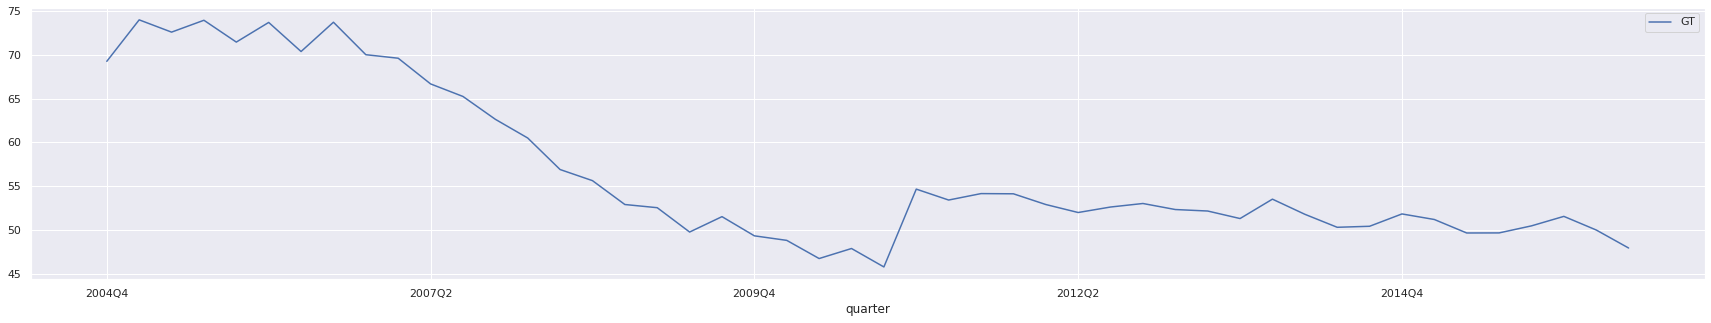

In [ ]:
train_GT_EDA.groupby('quarter')['GT'].mean().plot(figsize=(30,5), legend=True)

In [ ]:
train_GT_EDA.set_index('quarter', inplace=True)
train_GT_EDA.index = pd.PeriodIndex(pd.to_datetime(train_GT_EDA.index), freq='Q')

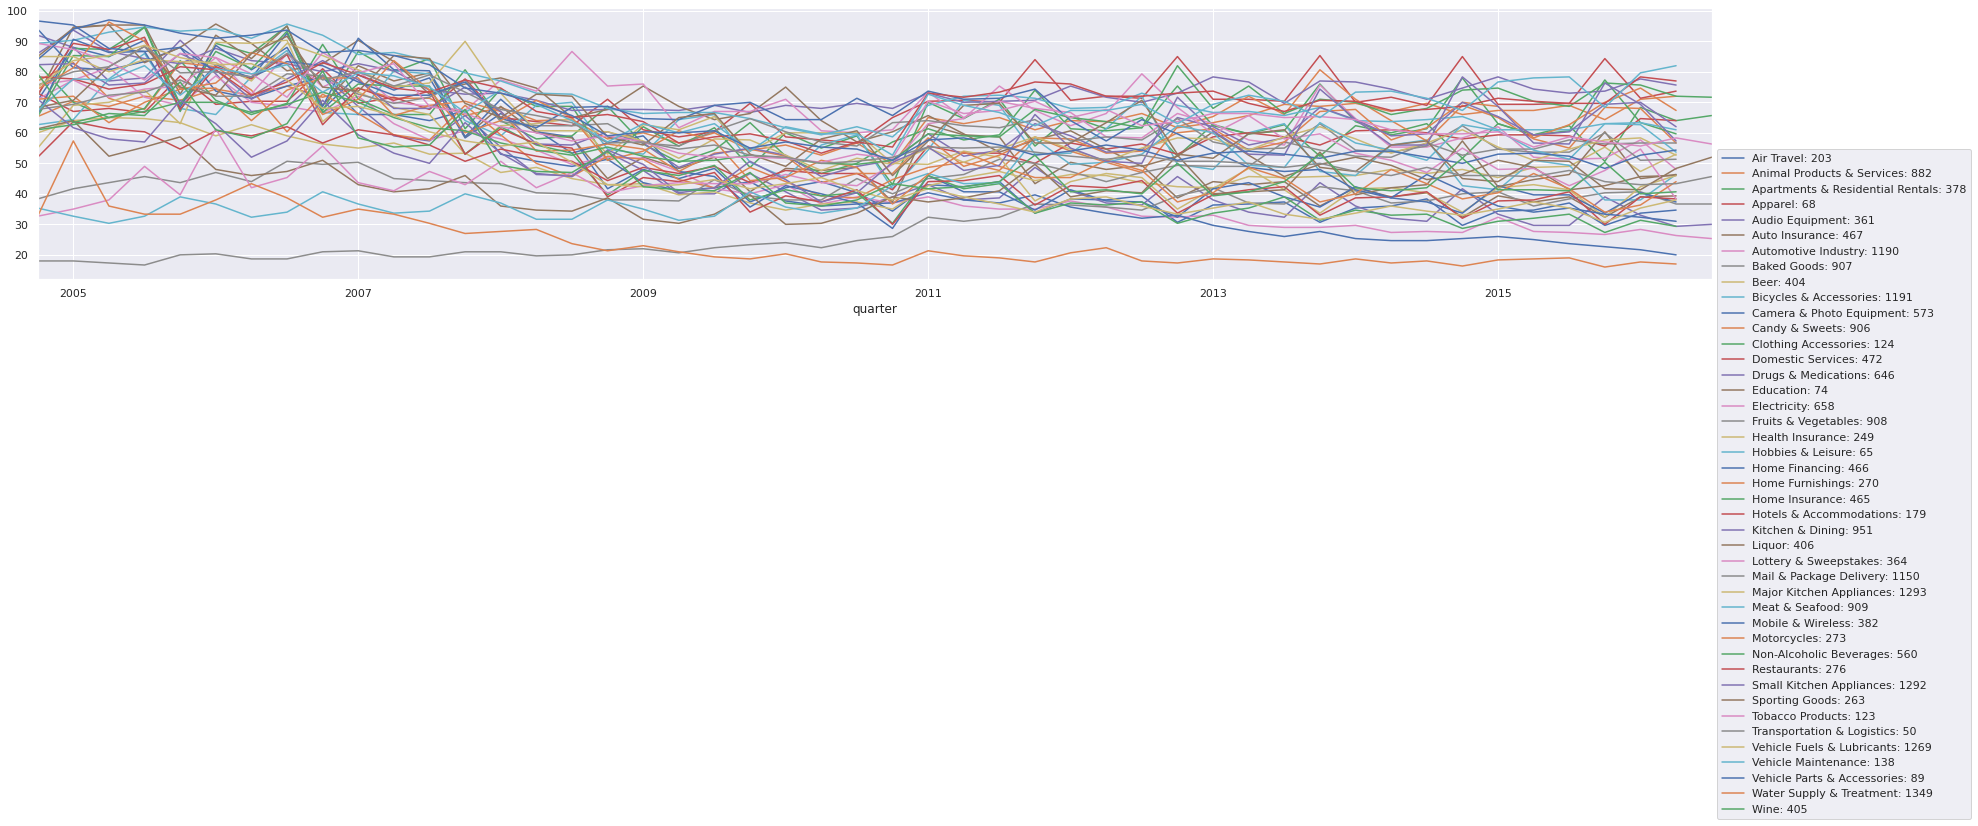

In [ ]:
train_GT_EDA.groupby('Categ_name')['GT'].plot(figsize=(30,5), legend=True)
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

There seems to be a seasonality for GT

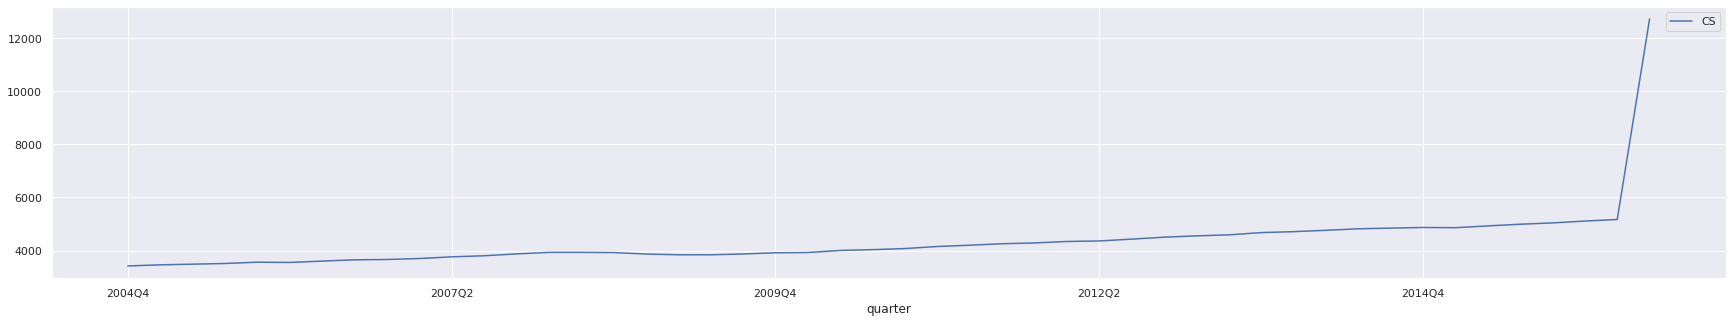

In [ ]:
train_CS_EDA=train_EDA.loc[:,['quarter','Categ_name','CS']]
train_CS_EDA.groupby('quarter')['CS'].mean().plot(figsize=(30,5), legend=True)

In [ ]:
train_CS_EDA.set_index('quarter', inplace=True)
train_CS_EDA.index = pd.PeriodIndex(pd.to_datetime(train_CS_EDA.index), freq='Q')

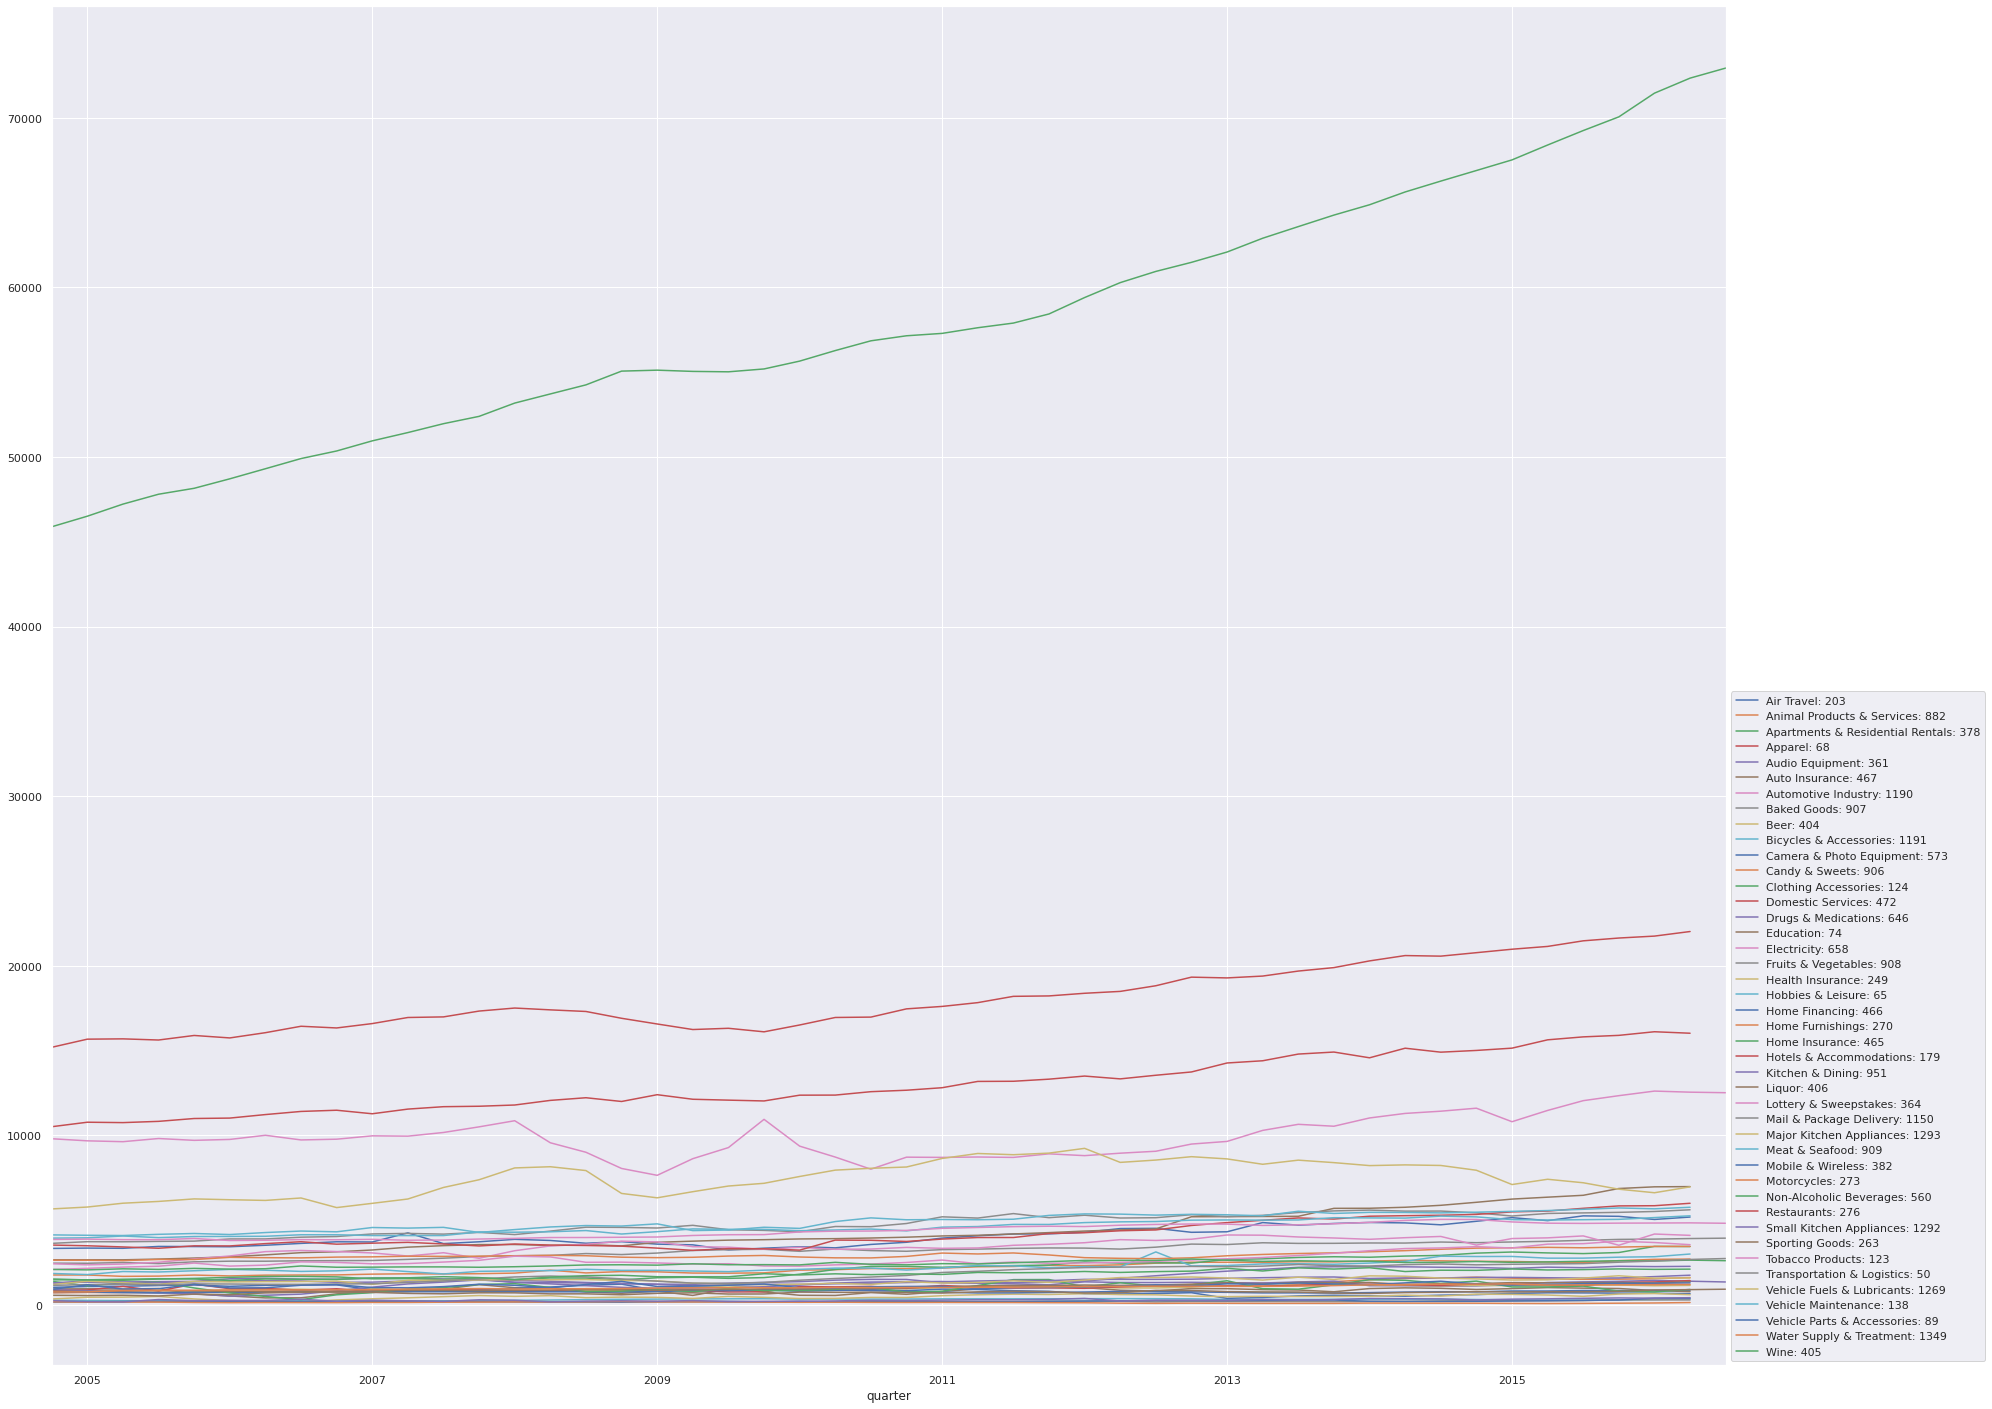

In [ ]:
train_CS_EDA.groupby('Categ_name')['CS'].plot(figsize=(30,25), legend=True)
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

There doesn'T seem to be any seasonnally.

In [ ]:
train_set_eda = train_EDA[train_EDA.Categ_name=='Automotive Industry: 1190']
train_set_eda.set_index('quarter', inplace=True)
train_set_eda.index = pd.PeriodIndex(pd.to_datetime(train_set_eda.index), freq='Q')
train_set_eda.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Automotive Industry: 1190,71.000000,6090,4.819667,-4.833333,77.1,12.500000,9793
2005Q1,Automotive Industry: 1190,77.333333,6074,4.881667,-3.366667,77.3,10.836667,9669
2005Q2,Automotive Industry: 1190,81.333333,6248,4.880667,-4.500000,78.0,11.336667,9619
2005Q3,Automotive Industry: 1190,71.666667,6161,4.609728,-4.533333,78.4,10.836667,9806
2005Q4,Automotive Industry: 1190,69.000000,6264,4.530333,-6.733333,78.8,12.873333,9698


Text(0, 0.5, 'cci')

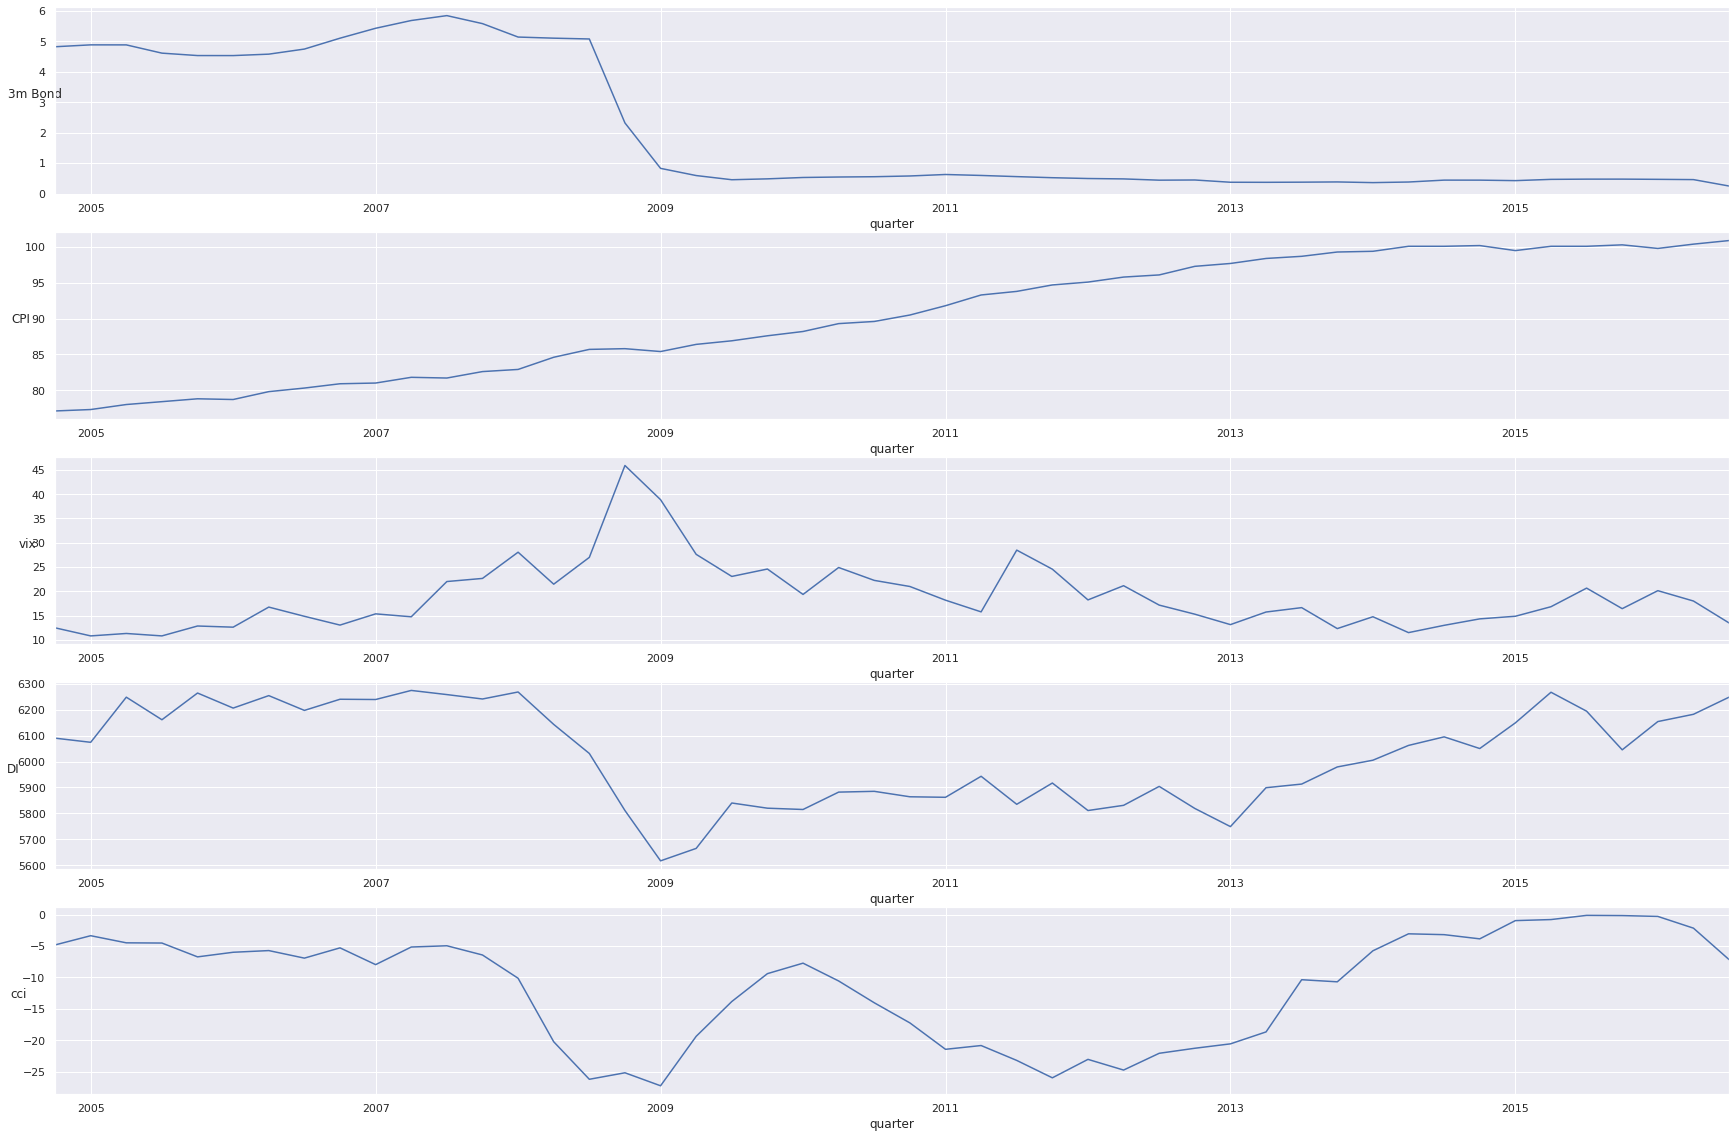

In [ ]:
plt.subplot(511)
train_set_eda['3m Bond'].plot(figsize=(30, 20))
plt.ylabel('3m Bond',rotation=0)

plt.subplot(512)
train_set_eda['CPI'].plot(figsize=(30, 20))
plt.ylabel('CPI',rotation=0)

plt.subplot(513)
train_set_eda['vix'].plot(figsize=(30, 20))
plt.ylabel('vix',rotation=0)

plt.subplot(514)
train_set_eda['DI'].plot(figsize=(30, 20))
plt.ylabel('DI',rotation=0)

plt.subplot(515)
train_set_eda['cci'].plot(figsize=(30, 20))
plt.ylabel('cci',rotation=0)

There seems to be a seasonal trend for vix.

# 5. Data cleaning and transformation

## 5.1 Stationarity tests

## KPSS and ADF test

Before any kind of model, we have to ensure the data is stationary. We will use the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests to test the series for stationarity.

We will conduct the tests only on the training data, determine which transformations are necessary, and apply them on both the training and test data.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

#creation of 2 styles to highlight whether the variables pass the ADF and KPSS tests
def color_ADF_green_5(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` in ADF<0.05 -->stationary, black otherwise.
    """
    color = 'green' if val < 0.05 else 'black'
    return 'color: %s' % color

def color_KPSS_green_5(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` in KPSS>0.05 -->stationary, black otherwise.
    """
    color = 'green' if val > 0.05 else 'black'
    return 'color: %s' % color

In [ ]:
Var = ['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix', 'CS']
ADF=[]
KPSS= []

for x in Var:
    print(x)
    # ADF test
    adf_pval = adfuller(train_set[x], maxlag=10, regression='nc')[1]
    print(f"ADF, p-value: {adf_pval}")
    ADF.append(adf_pval)
    # KPSS test
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set[x])
    print(f"KPSS, p-value: {kpss_pval}")
    print()
    KPSS.append(kpss_pval)

stationary_df = pd.DataFrame({'Var': Var, 'adf': ADF, 'kpss': KPSS})
stationary_df.set_index('Var', inplace=True)
stationary_df.style.format('{0:,.5f}')

stationary_df.style.applymap(color_ADF_green_5, subset=pd.IndexSlice['adf']).applymap(color_KPSS_green_5, subset=pd.IndexSlice['kpss'])

GT
ADF, p-value: 0.1987976204323733
KPSS, p-value: 0.01

DI
ADF, p-value: 0.7511002878876032
KPSS, p-value: 0.01

3m Bond
ADF, p-value: 0.0784127881269087
KPSS, p-value: 0.01

cci
ADF, p-value: 0.3869232636968572
KPSS, p-value: 0.01

CPI
ADF, p-value: 0.9999999999996007
KPSS, p-value: 0.01

vix


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-valu

ADF, p-value: 0.35406055654347685
KPSS, p-value: 0.01

CS
ADF, p-value: 2.7183619300118538e-11
KPSS, p-value: 0.01



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


,adf,kpss
Var,,
GT,0.198798,0.010000
DI,0.751100,0.010000
3m Bond,0.078413,0.010000
cci,0.386923,0.010000
CPI,1.000000,0.010000
vix,0.354061,0.010000
CS,0.000000,0.010000


### Info

The ADF test rejects the null hypothesis of non-stationnary for every variable, except Consumer Spending.

The KPSS test rejects the null hypothesis for every variable.

This seems odd because CS, CCI and DI were seasonnally adjusted according to ONS and Eurostat.

In this case, I will seasonnally adjust:
* GT,
* 3m Bond
* CPI
* vix

## 5.2 Log-transformation

### Do the log-transformation

In [ ]:
Season = ['GT', '3m Bond', 'CPI', 'vix']
ADF2=[]
KPSS2= []

for x in Season:
    print(x)
    logs = np.log(train_set[x])
    adf_pval = adfuller(logs, maxlag=10, regression='nc')[1]
    print(f"ADF, p-value: {adf_pval}")
    ADF2.append(adf_pval)
    kpss_stat, kpss_pval, lags, crit_vals = kpss(logs)
    print(f"KPSS, p-value: {kpss_pval}")
    print()
    KPSS2.append(kpss_pval)

stationary_df2 = pd.DataFrame({'Var': Season, 'adf': ADF2, 'kpss': KPSS2})
stationary_df2.set_index('Var', inplace=True)
stationary_df2.style.format('{0:,.5f}')

stationary_df2.style.applymap(color_ADF_green_5, subset=pd.IndexSlice['adf']).applymap(color_KPSS_green_5, subset=pd.IndexSlice['kpss'])

GT
ADF, p-value: 0.4832706407070591
KPSS, p-value: 0.01

3m Bond
ADF, p-value: 0.35734680899223803
KPSS, p-value: 0.01

CPI
ADF, p-value: 0.9999999999999203


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


KPSS, p-value: 0.01

vix
ADF, p-value: 0.6099570792089926
KPSS, p-value: 0.01



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


,adf,kpss
Var,,
GT,0.483271,0.010000
3m Bond,0.357347,0.010000
CPI,1.000000,0.010000
vix,0.609957,0.010000


The results haven't improved much. So, we won't use log-transformation

## 5.3 Differencing Seasonal - differencing

### 5.3.1 Prepare the datasets

Differentiate will produce a missing value at the start of the series, that we will drop. We must differentiate it for every cat needed and also transform before our dataset in order to drop only the same time period for every value.

In [ ]:
diff_train = pd.read_csv(path+'/train_set.csv', index_col='quarter')
diff_train.index = pd.PeriodIndex(pd.to_datetime(diff_train.index), freq='Q')
diff_train.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2004Q4,Air Travel: 203,70.666667,6090,4.819667,-4.833333,77.1,12.5,3324
2004Q4,Kitchen & Dining: 951,82.333333,6090,4.819667,-4.833333,77.1,12.5,1290
2004Q4,Water Supply & Treatment: 1349,32.666667,6090,4.819667,-4.833333,77.1,12.5,752
2004Q4,Transportation & Logistics: 50,75.666667,6090,4.819667,-4.833333,77.1,12.5,1145
2004Q4,Motorcycles: 273,74.333333,6090,4.819667,-4.833333,77.1,12.5,181


In [ ]:
diff_test = pd.read_csv(path+'/test_set.csv', index_col='quarter')

### 5.3.2 Google Trends

In [ ]:
GT_train = diff_train.loc[:, ['Categ_name','GT']]
GT_train.head()

,Categ_name,GT
quarter,,
2004Q4,Air Travel: 203,70.666667
2004Q4,Kitchen & Dining: 951,82.333333
2004Q4,Water Supply & Treatment: 1349,32.666667
2004Q4,Transportation & Logistics: 50,75.666667
2004Q4,Motorcycles: 273,74.333333


In [ ]:
GT_train_piv = pd.pivot_table(GT_train, index='quarter', values=['GT'],columns=['Categ_name'])
GT_train_piv=GT_train_piv.droplevel(0, axis=1)
GT_train_piv.head()

Categ_name,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004Q4,70.666667,65.333333,66.666667,73.000000,92.000000,72.000000,71.000000,18.000000,60.000000,62.666667,94.000000,77.000000,82.666667,52.000000,86.000000,85.000000,75.666667,38.333333,55.0,89.333333,65.666667,71.000000,65.333333,72.666667,82.333333,61.333333,32.666667,67.666667,85.000000,35.333333,96.666667,74.333333,61.000000,78.333333,71.000000,68.333333,89.333333,75.666667,75.000000,67.333333,84.000000,32.666667,79.333333
2005Q1,88.000000,70.333333,87.666667,67.000000,88.000000,94.666667,77.333333,18.000000,64.000000,64.333333,81.333333,83.000000,70.000000,63.666667,93.666667,94.333333,77.333333,41.666667,69.0,90.333333,90.666667,72.000000,85.333333,89.333333,82.666667,64.000000,35.000000,69.333333,85.000000,32.666667,95.333333,81.333333,62.666667,77.666667,61.666667,70.666667,87.333333,80.000000,83.666667,77.666667,94.000000,57.333333,63.333333
2005Q2,85.000000,68.666667,87.333333,68.000000,77.000000,95.333333,81.333333,17.333333,65.000000,77.666667,80.666667,71.333333,65.000000,61.333333,86.666667,95.333333,71.666667,43.666667,70.0,93.000000,86.333333,63.333333,85.000000,87.333333,75.666667,52.333333,38.000000,72.333333,80.000000,30.333333,87.666667,96.333333,65.000000,74.333333,58.000000,81.666667,83.333333,81.666667,85.333333,77.333333,97.000000,36.000000,66.333333
2005Q3,90.333333,72.000000,94.666667,66.666667,78.000000,95.333333,71.666667,16.666667,64.666667,86.000000,83.333333,67.666667,68.000000,60.333333,84.333333,83.000000,74.333333,45.666667,74.0,94.666667,86.666667,70.000000,94.666667,91.333333,76.333333,55.333333,49.000000,73.333333,84.000000,32.666667,86.666667,90.000000,67.000000,76.000000,57.000000,88.333333,77.333333,88.333333,88.666667,82.000000,95.333333,33.333333,65.666667
2005Q4,69.333333,70.666667,67.000000,78.666667,90.333333,72.666667,69.000000,20.000000,63.333333,68.000000,88.000000,83.000000,83.666667,54.666667,82.666667,88.000000,75.333333,43.666667,63.0,93.333333,68.333333,74.333333,69.333333,67.666667,86.000000,58.666667,39.666667,77.333333,83.333333,39.000000,88.000000,74.333333,70.000000,81.666667,70.666667,75.000000,86.000000,79.666667,84.666667,72.333333,92.666667,33.333333,76.666667


In [ ]:
diff_GT_train = GT_train_piv.diff()
diff_GT_train.head()

Categ_name,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005Q1,17.333333,5.000000,21.000000,-6.000000,-4.000000,22.666667,6.333333,0.000000,4.000000,1.666667,-12.666667,6.000000,-12.666667,11.666667,7.666667,9.333333,1.666667,3.333333,14.0,1.000000,25.000000,1.000000,20.000000,16.666667,0.333333,2.666667,2.333333,1.666667,0.000000,-2.666667,-1.333333,7.000000,1.666667,-0.666667,-9.333333,2.333333,-2.000000,4.333333,8.666667,10.333333,10.000000,24.666667,-16.000000
2005Q2,-3.000000,-1.666667,-0.333333,1.000000,-11.000000,0.666667,4.000000,-0.666667,1.000000,13.333333,-0.666667,-11.666667,-5.000000,-2.333333,-7.000000,1.000000,-5.666667,2.000000,1.0,2.666667,-4.333333,-8.666667,-0.333333,-2.000000,-7.000000,-11.666667,3.000000,3.000000,-5.000000,-2.333333,-7.666667,15.000000,2.333333,-3.333333,-3.666667,11.000000,-4.000000,1.666667,1.666667,-0.333333,3.000000,-21.333333,3.000000
2005Q3,5.333333,3.333333,7.333333,-1.333333,1.000000,0.000000,-9.666667,-0.666667,-0.333333,8.333333,2.666667,-3.666667,3.000000,-1.000000,-2.333333,-12.333333,2.666667,2.000000,4.0,1.666667,0.333333,6.666667,9.666667,4.000000,0.666667,3.000000,11.000000,1.000000,4.000000,2.333333,-1.000000,-6.333333,2.000000,1.666667,-1.000000,6.666667,-6.000000,6.666667,3.333333,4.666667,-1.666667,-2.666667,-0.666667
2005Q4,-21.000000,-1.333333,-27.666667,12.000000,12.333333,-22.666667,-2.666667,3.333333,-1.333333,-18.000000,4.666667,15.333333,15.666667,-5.666667,-1.666667,5.000000,1.000000,-2.000000,-11.0,-1.333333,-18.333333,4.333333,-25.333333,-23.666667,9.666667,3.333333,-9.333333,4.000000,-0.666667,6.333333,1.333333,-15.666667,3.000000,5.666667,13.666667,-13.333333,8.666667,-8.666667,-4.000000,-9.666667,-2.666667,0.000000,11.000000


In [ ]:
diff_GT_train.dropna(axis=0, inplace=True)
diff_GT_train.reset_index(inplace=True)
diff_GT_train = pd.melt(diff_GT_train, id_vars='quarter')
diff_GT_train.head()

,quarter,Categ_name,value
0,2005Q1,Air Travel: 203,17.333333
1,2005Q2,Air Travel: 203,-3.000000
2,2005Q3,Air Travel: 203,5.333333
3,2005Q4,Air Travel: 203,-21.000000
4,2006Q1,Air Travel: 203,13.000000


In [ ]:
diff_GT_train.rename(columns={'value': 'GT'}, inplace=True)
diff_GT_train.head()

,quarter,Categ_name,GT
0,2005Q1,Air Travel: 203,17.333333
1,2005Q2,Air Travel: 203,-3.000000
2,2005Q3,Air Travel: 203,5.333333
3,2005Q4,Air Travel: 203,-21.000000
4,2006Q1,Air Travel: 203,13.000000


In [ ]:
# Transform type of quarter to string
diff_GT_train['quarter']=diff_GT_train['quarter'].astype(str)
diff_GT_train['quarter_cat'] = diff_GT_train['quarter']+'_'+diff_GT_train['Categ_name']
diff_GT_train.head()

,quarter,Categ_name,GT,quarter_cat
0,2005Q1,Air Travel: 203,17.333333,2005Q1_Air Travel: 203
1,2005Q2,Air Travel: 203,-3.000000,2005Q2_Air Travel: 203
2,2005Q3,Air Travel: 203,5.333333,2005Q3_Air Travel: 203
3,2005Q4,Air Travel: 203,-21.000000,2005Q4_Air Travel: 203
4,2006Q1,Air Travel: 203,13.000000,2006Q1_Air Travel: 203


In [ ]:
diff_GT_train.to_csv(path+'/diff_GT_train.csv')

We do the same for the test set.

In [ ]:
GT_test = diff_test.loc[:, ['Categ_name','GT']]
GT_test_piv = pd.pivot_table(GT_test, index='quarter', values=['GT'],columns=['Categ_name'])
GT_test_piv=GT_test_piv.droplevel(0, axis=1)
GT_test_piv.head()

Categ_name,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016Q3,37.666667,74.666667,NaN,73.000000,NaN,39.333333,NaN,NaN,51.000000,50.333333,20.000000,56.333333,63.000000,64.333333,72.666667,39.666667,47.000000,58.666667,41.666667,62.666667,40.000000,68.333333,32.666667,42.000000,64.000000,49.000000,36.333333,51.000000,56.000000,53.666667,37.000000,40.333333,NaN,80.000000,56.333333,NaN,NaN,NaN,36.333333,88.333333,53.666667,17.000000,41.666667
2016Q4,29.333333,69.000000,54.000000,90.666667,41.333333,33.666667,25.666667,41.333333,52.000000,39.333333,21.666667,74.666667,81.666667,61.333333,75.666667,41.666667,51.666667,58.333333,34.333333,63.666667,34.000000,75.666667,26.333333,32.000000,76.000000,64.333333,37.333333,59.000000,61.333333,66.666667,36.333333,34.000000,81.333333,81.666667,79.666667,44.333333,56.333333,43.666667,36.000000,75.333333,49.666667,16.000000,53.666667
2017Q1,33.333333,72.000000,64.333333,72.666667,33.333333,39.333333,28.666667,40.000000,51.666667,38.000000,20.333333,64.333333,64.333333,66.333333,82.000000,45.333333,56.333333,58.000000,42.666667,59.000000,41.000000,74.666667,30.000000,37.333333,70.666667,46.666667,32.666667,52.333333,56.000000,61.000000,34.000000,35.333333,79.333333,82.666667,67.333333,42.000000,59.000000,42.333333,37.333333,82.333333,53.000000,17.666667,40.666667
2017Q2,35.333333,73.666667,62.666667,75.000000,30.666667,39.000000,26.333333,37.333333,55.000000,47.333333,18.666667,60.666667,60.666667,68.333333,80.333333,42.666667,48.333333,60.333333,46.000000,61.666667,38.000000,64.000000,31.000000,39.666667,67.666667,52.333333,36.333333,53.333333,54.000000,57.666667,31.333333,42.000000,78.333333,83.333333,71.000000,50.000000,60.666667,42.666667,39.333333,83.333333,54.333333,18.333333,41.666667
2017Q3,39.000000,80.666667,67.333333,77.666667,31.666667,42.666667,25.333333,40.333333,54.666667,48.666667,19.333333,58.333333,66.333333,69.666667,81.666667,40.000000,50.666667,64.000000,43.666667,62.666667,40.333333,72.666667,33.666667,42.333333,71.666667,56.333333,35.666667,57.333333,59.333333,57.000000,35.333333,37.333333,79.666667,88.333333,64.000000,52.333333,60.333333,46.333333,37.666667,84.000000,55.000000,18.666667,44.000000


In [ ]:
# we must drop the first row before differentiating the data.

GT_test_piv=GT_test_piv.iloc[1:]
GT_test_piv.head()

Categ_name,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016Q4,29.333333,69.000000,54.000000,90.666667,41.333333,33.666667,25.666667,41.333333,52.000000,39.333333,21.666667,74.666667,81.666667,61.333333,75.666667,41.666667,51.666667,58.333333,34.333333,63.666667,34.000000,75.666667,26.333333,32.000000,76.000000,64.333333,37.333333,59.000000,61.333333,66.666667,36.333333,34.000000,81.333333,81.666667,79.666667,44.333333,56.333333,43.666667,36.000000,75.333333,49.666667,16.000000,53.666667
2017Q1,33.333333,72.000000,64.333333,72.666667,33.333333,39.333333,28.666667,40.000000,51.666667,38.000000,20.333333,64.333333,64.333333,66.333333,82.000000,45.333333,56.333333,58.000000,42.666667,59.000000,41.000000,74.666667,30.000000,37.333333,70.666667,46.666667,32.666667,52.333333,56.000000,61.000000,34.000000,35.333333,79.333333,82.666667,67.333333,42.000000,59.000000,42.333333,37.333333,82.333333,53.000000,17.666667,40.666667
2017Q2,35.333333,73.666667,62.666667,75.000000,30.666667,39.000000,26.333333,37.333333,55.000000,47.333333,18.666667,60.666667,60.666667,68.333333,80.333333,42.666667,48.333333,60.333333,46.000000,61.666667,38.000000,64.000000,31.000000,39.666667,67.666667,52.333333,36.333333,53.333333,54.000000,57.666667,31.333333,42.000000,78.333333,83.333333,71.000000,50.000000,60.666667,42.666667,39.333333,83.333333,54.333333,18.333333,41.666667
2017Q3,39.000000,80.666667,67.333333,77.666667,31.666667,42.666667,25.333333,40.333333,54.666667,48.666667,19.333333,58.333333,66.333333,69.666667,81.666667,40.000000,50.666667,64.000000,43.666667,62.666667,40.333333,72.666667,33.666667,42.333333,71.666667,56.333333,35.666667,57.333333,59.333333,57.000000,35.333333,37.333333,79.666667,88.333333,64.000000,52.333333,60.333333,46.333333,37.666667,84.000000,55.000000,18.666667,44.000000
2017Q4,30.666667,74.666667,56.000000,95.000000,43.333333,34.333333,27.333333,42.000000,57.333333,38.333333,20.333333,74.333333,85.666667,65.333333,87.333333,42.666667,52.333333,62.333333,36.666667,64.666667,37.333333,80.666667,27.666667,32.666667,81.333333,74.000000,37.333333,65.666667,62.666667,69.666667,35.333333,31.000000,84.000000,88.666667,85.333333,42.333333,58.666667,44.666667,34.000000,76.000000,51.333333,17.000000,54.333333


In [ ]:
diff_GT_test = GT_test_piv.diff()
diff_GT_test.head()

Categ_name,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017Q1,4.000000,3.000000,10.333333,-18.000000,-8.000000,5.666667,3.000000,-1.333333,-0.333333,-1.333333,-1.333333,-10.333333,-17.333333,5.000000,6.333333,3.666667,4.666667,-0.333333,8.333333,-4.666667,7.000000,-1.000000,3.666667,5.333333,-5.333333,-17.666667,-4.666667,-6.666667,-5.333333,-5.666667,-2.333333,1.333333,-2.000000,1.000000,-12.333333,-2.333333,2.666667,-1.333333,1.333333,7.000000,3.333333,1.666667,-13.000000
2017Q2,2.000000,1.666667,-1.666667,2.333333,-2.666667,-0.333333,-2.333333,-2.666667,3.333333,9.333333,-1.666667,-3.666667,-3.666667,2.000000,-1.666667,-2.666667,-8.000000,2.333333,3.333333,2.666667,-3.000000,-10.666667,1.000000,2.333333,-3.000000,5.666667,3.666667,1.000000,-2.000000,-3.333333,-2.666667,6.666667,-1.000000,0.666667,3.666667,8.000000,1.666667,0.333333,2.000000,1.000000,1.333333,0.666667,1.000000
2017Q3,3.666667,7.000000,4.666667,2.666667,1.000000,3.666667,-1.000000,3.000000,-0.333333,1.333333,0.666667,-2.333333,5.666667,1.333333,1.333333,-2.666667,2.333333,3.666667,-2.333333,1.000000,2.333333,8.666667,2.666667,2.666667,4.000000,4.000000,-0.666667,4.000000,5.333333,-0.666667,4.000000,-4.666667,1.333333,5.000000,-7.000000,2.333333,-0.333333,3.666667,-1.666667,0.666667,0.666667,0.333333,2.333333
2017Q4,-8.333333,-6.000000,-11.333333,17.333333,11.666667,-8.333333,2.000000,1.666667,2.666667,-10.333333,1.000000,16.000000,19.333333,-4.333333,5.666667,2.666667,1.666667,-1.666667,-7.000000,2.000000,-3.000000,8.000000,-6.000000,-9.666667,9.666667,17.666667,1.666667,8.333333,3.333333,12.666667,0.000000,-6.333333,4.333333,0.333333,21.333333,-10.000000,-1.666667,-1.666667,-3.666667,-8.000000,-3.666667,-1.666667,10.333333


In [ ]:
diff_GT_test.dropna(axis=0, inplace=True)
diff_GT_test.reset_index(inplace=True)
diff_GT_test = pd.melt(diff_GT_test, id_vars='quarter')
diff_GT_test.head()

,quarter,Categ_name,value
0,2017Q1,Air Travel: 203,4.000000
1,2017Q2,Air Travel: 203,2.000000
2,2017Q3,Air Travel: 203,3.666667
3,2017Q4,Air Travel: 203,-8.333333
4,2018Q1,Air Travel: 203,4.666667


In [ ]:
diff_GT_test.rename(columns={'value': 'GT'}, inplace=True)

# Transform type of quarter to string
diff_GT_test['quarter']=diff_GT_test['quarter'].astype(str)
diff_GT_test['quarter_cat'] = diff_GT_test['quarter']+'_'+diff_GT_test['Categ_name']
diff_GT_test.head()

,quarter,Categ_name,GT,quarter_cat
0,2017Q1,Air Travel: 203,4.000000,2017Q1_Air Travel: 203
1,2017Q2,Air Travel: 203,2.000000,2017Q2_Air Travel: 203
2,2017Q3,Air Travel: 203,3.666667,2017Q3_Air Travel: 203
3,2017Q4,Air Travel: 203,-8.333333,2017Q4_Air Travel: 203
4,2018Q1,Air Travel: 203,4.666667,2018Q1_Air Travel: 203


In [ ]:
diff_GT_test.to_csv(path+'/diff_GT_test.csv')

### 5.3.3 The other variables

In [ ]:
def to_diff(X):
   # create a dataframe for the variable with the categ name and the variable
   X_train = diff_train.loc[:, ['Categ_name',X]]
   # creation of a pivot table. We put categories as header
   X_train_piv = pd.pivot_table(X_train, index='quarter', values=[X],columns=['Categ_name'])
   # we drop the 1st level
   X_train_piv=X_train_piv.droplevel(0, axis=1)
   # we differentiate the variable
   diff_X_train = X_train_piv.diff()
   # we drop the first row because it has Nan values
   diff_X_train.dropna(axis=0, inplace=True)
   diff_X_train.reset_index(inplace=True)
   # we put all the columns in one single columns using the melt function
   diff_X_train = pd.melt(diff_X_train, id_vars='quarter')
   # We rename properly the column value with the name of the variable
   diff_X_train.rename(columns={'value': X}, inplace=True)
   # Creation of a column combining the quarter and the category to merge it with the initial dataset
  # Transform type of quarter to string
   diff_X_train['quarter']=diff_X_train['quarter'].astype(str)
   diff_X_train['quarter_cat'] = diff_X_train['quarter']+'_'+diff_X_train['Categ_name']
   # save the file
   diff_X_train.to_csv(path+'/diff_'+X+'_train.csv')
   return print(diff_X_train.head())

In [ ]:
train_diff=['vix','3m Bond', 'CPI']

for i in train_diff:
  to_diff(i)

  quarter       Categ_name       vix             quarter_cat
0  2005Q1  Air Travel: 203 -1.663333  2005Q1_Air Travel: 203
1  2005Q2  Air Travel: 203  0.500000  2005Q2_Air Travel: 203
2  2005Q3  Air Travel: 203 -0.500000  2005Q3_Air Travel: 203
3  2005Q4  Air Travel: 203  2.036667  2005Q4_Air Travel: 203
4  2006Q1  Air Travel: 203 -0.240000  2006Q1_Air Travel: 203
  quarter       Categ_name   3m Bond             quarter_cat
0  2005Q1  Air Travel: 203  0.062000  2005Q1_Air Travel: 203
1  2005Q2  Air Travel: 203 -0.001000  2005Q2_Air Travel: 203
2  2005Q3  Air Travel: 203 -0.270938  2005Q3_Air Travel: 203
3  2005Q4  Air Travel: 203 -0.079395  2005Q4_Air Travel: 203
4  2006Q1  Air Travel: 203 -0.000825  2006Q1_Air Travel: 203
  quarter       Categ_name  CPI             quarter_cat
0  2005Q1  Air Travel: 203  0.2  2005Q1_Air Travel: 203
1  2005Q2  Air Travel: 203  0.7  2005Q2_Air Travel: 203
2  2005Q3  Air Travel: 203  0.4  2005Q3_Air Travel: 203
3  2005Q4  Air Travel: 203  0.4  2005Q4_Air 

In [ ]:
diff_vix_train=pd.read_csv(path+'/diff_vix_train.csv')
diff_vix_train.drop('Unnamed: 0', axis=1, inplace=True)
diff_vix_train.head()

,quarter,Categ_name,vix,quarter_cat
0,2005Q1,Air Travel: 203,-1.663333,2005Q1_Air Travel: 203
1,2005Q2,Air Travel: 203,0.500000,2005Q2_Air Travel: 203
2,2005Q3,Air Travel: 203,-0.500000,2005Q3_Air Travel: 203
3,2005Q4,Air Travel: 203,2.036667,2005Q4_Air Travel: 203
4,2006Q1,Air Travel: 203,-0.240000,2006Q1_Air Travel: 203


In [ ]:
train_diff_GT_vix=diff_GT_train.merge(diff_vix_train[['quarter_cat','vix']], left_on='quarter_cat', right_on='quarter_cat')
train_diff_GT_vix.head()

,quarter,Categ_name,GT,quarter_cat,vix
0,2005Q1,Air Travel: 203,17.333333,2005Q1_Air Travel: 203,-1.663333
1,2005Q2,Air Travel: 203,-3.000000,2005Q2_Air Travel: 203,0.500000
2,2005Q3,Air Travel: 203,5.333333,2005Q3_Air Travel: 203,-0.500000
3,2005Q4,Air Travel: 203,-21.000000,2005Q4_Air Travel: 203,2.036667
4,2006Q1,Air Travel: 203,13.000000,2006Q1_Air Travel: 203,-0.240000


In [ ]:
diff_3m_train= pd.read_csv(path+'/diff_3m Bond_train.csv')
diff_3m_train.drop('Unnamed: 0', axis=1, inplace=True)
diff_3m_train.head()

,quarter,Categ_name,3m Bond,quarter_cat
0,2005Q1,Air Travel: 203,0.062000,2005Q1_Air Travel: 203
1,2005Q2,Air Travel: 203,-0.001000,2005Q2_Air Travel: 203
2,2005Q3,Air Travel: 203,-0.270938,2005Q3_Air Travel: 203
3,2005Q4,Air Travel: 203,-0.079395,2005Q4_Air Travel: 203
4,2006Q1,Air Travel: 203,-0.000825,2006Q1_Air Travel: 203


In [ ]:
train_diff_GT_vix_3m = train_diff_GT_vix.merge(diff_3m_train[['quarter_cat','3m Bond']], left_on='quarter_cat', right_on='quarter_cat')
train_diff_GT_vix_3m.head()

,quarter,Categ_name,GT,quarter_cat,vix,3m Bond
0,2005Q1,Air Travel: 203,17.333333,2005Q1_Air Travel: 203,-1.663333,0.062000
1,2005Q2,Air Travel: 203,-3.000000,2005Q2_Air Travel: 203,0.500000,-0.001000
2,2005Q3,Air Travel: 203,5.333333,2005Q3_Air Travel: 203,-0.500000,-0.270938
3,2005Q4,Air Travel: 203,-21.000000,2005Q4_Air Travel: 203,2.036667,-0.079395
4,2006Q1,Air Travel: 203,13.000000,2006Q1_Air Travel: 203,-0.240000,-0.000825


In [ ]:
diff_CPI_train= pd.read_csv(path+'/diff_CPI_train.csv')
diff_CPI_train.drop('Unnamed: 0', axis=1, inplace=True)
train_diff_var = train_diff_GT_vix_3m.merge(diff_CPI_train[['quarter_cat','CPI']], left_on='quarter_cat', right_on='quarter_cat')
train_diff_var.head()

,quarter,Categ_name,GT,quarter_cat,vix,3m Bond,CPI
0,2005Q1,Air Travel: 203,17.333333,2005Q1_Air Travel: 203,-1.663333,0.062000,0.2
1,2005Q2,Air Travel: 203,-3.000000,2005Q2_Air Travel: 203,0.500000,-0.001000,0.7
2,2005Q3,Air Travel: 203,5.333333,2005Q3_Air Travel: 203,-0.500000,-0.270938,0.4
3,2005Q4,Air Travel: 203,-21.000000,2005Q4_Air Travel: 203,2.036667,-0.079395,0.4
4,2006Q1,Air Travel: 203,13.000000,2006Q1_Air Travel: 203,-0.240000,-0.000825,-0.1


In [ ]:
train_diff_var.to_csv(path+'/train_diff_var.csv')

In [ ]:
train_copy = diff_train.loc[:,['Categ_name','cci', 'DI','CS']]
train_copy.head()

,Categ_name,cci,DI,CS
quarter,,,,
2004Q4,Air Travel: 203,-4.833333,6090,3324
2004Q4,Kitchen & Dining: 951,-4.833333,6090,1290
2004Q4,Water Supply & Treatment: 1349,-4.833333,6090,752
2004Q4,Transportation & Logistics: 50,-4.833333,6090,1145
2004Q4,Motorcycles: 273,-4.833333,6090,181


In [ ]:
train_copy.reset_index(inplace=True)
train_copy['quarter']=train_copy['quarter'].astype(str)
train_copy['quarter_cat'] = train_copy['quarter']+'_'+train_copy['Categ_name']
train_copy.head()

,quarter,Categ_name,cci,DI,CS,quarter_cat
0,2004Q4,Air Travel: 203,-4.833333,6090,3324,2004Q4_Air Travel: 203
1,2004Q4,Kitchen & Dining: 951,-4.833333,6090,1290,2004Q4_Kitchen & Dining: 951
2,2004Q4,Water Supply & Treatment: 1349,-4.833333,6090,752,2004Q4_Water Supply & Treatment: 1349
3,2004Q4,Transportation & Logistics: 50,-4.833333,6090,1145,2004Q4_Transportation & Logistics: 50
4,2004Q4,Motorcycles: 273,-4.833333,6090,181,2004Q4_Motorcycles: 273


In [ ]:
train_var = train_copy.merge(train_diff_var[['quarter_cat','GT','vix','3m Bond','CPI']], left_on='quarter_cat', right_on='quarter_cat')
train_var.head()

,quarter,Categ_name,cci,DI,CS,quarter_cat,GT,vix,3m Bond,CPI
0,2005Q1,Mail & Package Delivery: 1150,-3.366667,6074,185,2005Q1_Mail & Package Delivery: 1150,1.666667,-1.663333,0.062,0.2
1,2005Q1,Kitchen & Dining: 951,-3.366667,6074,1337,2005Q1_Kitchen & Dining: 951,0.333333,-1.663333,0.062,0.2
2,2005Q1,Animal Products & Services: 882,-3.366667,6074,730,2005Q1_Animal Products & Services: 882,5.000000,-1.663333,0.062,0.2
3,2005Q1,Auto Insurance: 467,-3.366667,6074,943,2005Q1_Auto Insurance: 467,22.666667,-1.663333,0.062,0.2
4,2005Q1,Meat & Seafood: 909,-3.366667,6074,3951,2005Q1_Meat & Seafood: 909,-2.666667,-1.663333,0.062,0.2


In [ ]:
train_final=train_var.loc[:,['quarter','Categ_name','cci','DI','CS','GT','vix','3m Bond', 'CPI']]
train_final.set_index('quarter', inplace=True)
train_final.index = pd.PeriodIndex(pd.to_datetime(train_final.index), freq='Q')
train_final.head()

,Categ_name,cci,DI,CS,GT,vix,3m Bond,CPI
quarter,,,,,,,,
2005Q1,Mail & Package Delivery: 1150,-3.366667,6074,185,1.666667,-1.663333,0.062,0.2
2005Q1,Kitchen & Dining: 951,-3.366667,6074,1337,0.333333,-1.663333,0.062,0.2
2005Q1,Animal Products & Services: 882,-3.366667,6074,730,5.000000,-1.663333,0.062,0.2
2005Q1,Auto Insurance: 467,-3.366667,6074,943,22.666667,-1.663333,0.062,0.2
2005Q1,Meat & Seafood: 909,-3.366667,6074,3951,-2.666667,-1.663333,0.062,0.2


In [ ]:
train_final.to_csv(path+'/train_diff_59.csv')

### 5.3.4 Differencing the test data

In [ ]:
diff_test = pd.read_csv(path+'/test_set.csv', index_col='quarter')
diff_test.index = pd.PeriodIndex(pd.to_datetime(diff_test.index), freq='Q')
diff_test.head()

,Categ_name,GT,DI,3m Bond,cci,CPI,vix,CS
quarter,,,,,,,,
2016Q3,Camera & Photo Equipment: 573,20.000000,6248,0.246667,-7.166667,100.9,13.5,634
2016Q3,Candy & Sweets: 906,56.333333,6248,0.246667,-7.166667,100.9,13.5,2729
2016Q3,Motorcycles: 273,40.333333,6248,0.246667,-7.166667,100.9,13.5,142
2016Q3,Vehicle Parts & Accessories: 89,53.666667,6248,0.246667,-7.166667,100.9,13.5,1282
2016Q3,Water Supply & Treatment: 1349,17.000000,6248,0.246667,-7.166667,100.9,13.5,1209


In [ ]:
def to_diff_test(X):
   # create a dataframe for the variable with the categ name and the variable
   X_test = diff_test.loc[:, ['Categ_name',X]]
   # creation of a pivot table. We put categories as header
   X_test_piv = pd.pivot_table(X_test, index='quarter', values=[X],columns=['Categ_name'])
   # we drop the 1st level
   X_test_piv=X_test_piv.droplevel(0, axis=1)
   # we differentiate the variable
   diff_X_test = X_test_piv.diff()
   # we drop the first row because it has Nan values
   diff_X_test.dropna(axis=0, inplace=True)
   diff_X_test.reset_index(inplace=True)
   # we put all the columns in one single columns using the melt function
   diff_X_test = pd.melt(diff_X_test, id_vars='quarter')
   # We rename properly the column value with the name of the variable
   diff_X_test.rename(columns={'value': X}, inplace=True)
   # Creation of a column combining the quarter and the category to merge it with the initial dataset
  # Transform type of quarter to string
   diff_X_test['quarter']=diff_X_test['quarter'].astype(str)
   diff_X_test['quarter_cat'] = diff_X_test['quarter']+'_'+diff_X_test['Categ_name']
   # save the file
   diff_X_test.to_csv(path+'/diff_'+X+'_test.csv')
   return print(diff_X_test.head())

In [ ]:
test_diff=['vix','3m Bond', 'CPI']

for i in test_diff:
  to_diff_test(i)

  quarter       Categ_name       vix             quarter_cat
0  2017Q1  Air Travel: 203 -2.556667  2017Q1_Air Travel: 203
1  2017Q2  Air Travel: 203  0.000000  2017Q2_Air Travel: 203
2  2017Q3  Air Travel: 203 -0.993333  2017Q3_Air Travel: 203
3  2017Q4  Air Travel: 203 -0.893333  2017Q4_Air Travel: 203
4  2018Q1  Air Travel: 203  3.383333  2018Q1_Air Travel: 203
  quarter       Categ_name   3m Bond             quarter_cat
0  2017Q1  Air Travel: 203  0.000667  2017Q1_Air Travel: 203
1  2017Q2  Air Travel: 203 -0.034000  2017Q2_Air Travel: 203
2  2017Q3  Air Travel: 203  0.016000  2017Q3_Air Travel: 203
3  2017Q4  Air Travel: 203  0.168667  2017Q4_Air Travel: 203
4  2018Q1  Air Travel: 203  0.004333  2018Q1_Air Travel: 203
  quarter       Categ_name  CPI             quarter_cat
0  2017Q1  Air Travel: 203  0.5  2017Q1_Air Travel: 203
1  2017Q2  Air Travel: 203  1.2  2017Q2_Air Travel: 203
2  2017Q3  Air Travel: 203  0.5  2017Q3_Air Travel: 203
3  2017Q4  Air Travel: 203  0.9  2017Q4_Air 

In [ ]:
# Put each file with the differenciated variables in a dataframe
diff_vix_test= pd.read_csv(path+'/diff_vix_test.csv')
diff_vix_test.drop('Unnamed: 0', axis=1, inplace=True)
diff_3m_test= pd.read_csv(path+'/diff_3m Bond_test.csv')
diff_3m_test.drop('Unnamed: 0', axis=1, inplace=True)
diff_CPI_test= pd.read_csv(path+'/diff_CPI_test.csv')
diff_CPI_test.drop('Unnamed: 0', axis=1, inplace=True)

# Merging the dataframe 2 by 2
test_diff_GT_vix=diff_GT_test.merge(diff_vix_test[['quarter_cat','vix']], left_on='quarter_cat', right_on='quarter_cat')
test_diff_3m_CPI=diff_CPI_test.merge(diff_3m_test[['quarter_cat','3m Bond']], left_on='quarter_cat', right_on='quarter_cat')
# Merge the 2 dataframes
test_diff_var=test_diff_GT_vix.merge(test_diff_3m_CPI[['quarter_cat','3m Bond', 'CPI']], left_on='quarter_cat', right_on='quarter_cat')

# Copy the test dataframe with the variables which weren't differentiated
test_copy = diff_test.loc[:,['Categ_name','cci', 'DI','CS']]

# create a column combining the quarter and the category to merge this dataframe with the dataframe containng the variables
test_copy.reset_index(inplace=True)
test_copy['quarter']=test_copy['quarter'].astype(str)
test_copy['quarter_cat'] = test_copy['quarter']+'_'+test_copy['Categ_name']

In [ ]:
#Merge the 2 dataframes
test_var = test_copy.merge(test_diff_var[['quarter_cat','GT','vix','3m Bond','CPI']], left_on='quarter_cat', right_on='quarter_cat')

# Creation of a new dataframe with only the columns we want
test_final=test_var.loc[:,['quarter','Categ_name','cci','DI','CS','GT','vix','3m Bond', 'CPI']]
test_final.set_index('quarter', inplace=True)
test_final.index = pd.PeriodIndex(pd.to_datetime(test_final.index), freq='Q')

# Save the final test dataframe
test_final.to_csv(path+'/test_diff_59.csv')
test_final.head()

,Categ_name,cci,DI,CS,GT,vix,3m Bond,CPI
quarter,,,,,,,,
2017Q1,Wine: 405,-6.2,6375,2172,-13.000000,-2.556667,0.000667,0.5
2017Q1,Tobacco Products: 123,-6.2,6375,4725,2.666667,-2.556667,0.000667,0.5
2017Q1,Automotive Industry: 1190,-6.2,6375,12570,3.000000,-2.556667,0.000667,0.5
2017Q1,Home Insurance: 465,-6.2,6375,1080,3.666667,-2.556667,0.000667,0.5
2017Q1,Liquor: 406,-6.2,6375,1343,-17.666667,-2.556667,0.000667,0.5


### 5.3.4 Check the seasonality of the train dataset with ADF and KPSS tests

In [ ]:
Season = ['GT', '3m Bond', 'CPI', 'vix']
ADF_diff=[]
KPSS_diff= []

for x in Season:
    print(x)
    adf_pval = adfuller(train_final[x])[1]
    print(f"ADF, p-value: {adf_pval}")
    ADF_diff.append(adf_pval)
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_final[x])
    print(f"KPSS, p-value: {kpss_pval}")
    print()
    KPSS_diff.append(kpss_pval)

stationary_diff = pd.DataFrame({'Var': Season, 'adf': ADF_diff, 'kpss': KPSS_diff})
stationary_diff.set_index('Var', inplace=True)
stationary_diff.style.format('{0:,.5f}')

stationary_diff.style.applymap(color_ADF_green_5, subset=pd.IndexSlice['adf']).applymap(color_KPSS_green_5, subset=pd.IndexSlice['kpss'])

GT
ADF, p-value: 2.3190284132609853e-18
KPSS, p-value: 0.1

3m Bond
ADF, p-value: 0.00623392646495588
KPSS, p-value: 0.09425024230173948

CPI


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ADF, p-value: 6.847860159165886e-05
KPSS, p-value: 0.01

vix
ADF, p-value: 1.2294018255368798e-05
KPSS, p-value: 0.1



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


,adf,kpss
Var,,
GT,0.000000,0.100000
3m Bond,0.006234,0.094250
CPI,0.000068,0.010000
vix,0.000012,0.100000


Both tests indicate that all variables have become stationnary after first-differencing, except CPI, which failed the KPSS test (under 0.05) but passed the ADF one. However it can pass the KPSS test with a 99% interval confidence.